# Wavelet Transform

In [2]:
import os
import time
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import pandas as pd
from sklearn.metrics import mean_squared_error

#from wavelets.wave_python.waveletFunctions import *
import itertools
from scipy.fftpack import fft
from collections import defaultdict,Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib import cm, ticker
import scipy.io as sio
from IPython.display import display
import scipy.stats
import datetime as dt
from sklearn.ensemble import GradientBoostingClassifier
import scipy.signal as sgn
from scipy.integrate import simpson


from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import EngFormatter

from analysis_functions import *

#from wavelets.wave_python.waveletFunctions import *
print('Loaded')



data_dir = "../../data/"
suffixes = [f"{i:03d}" for i in range(170)]

sufix = 1
sample = 2  #0 - 9999
sample_frequency = 25e6 

samples = load_samples(data_dir,f"{sufix:03d}")

i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]
iq_signal = np.array(i_signal + 1J*q_signal, dtype=complex)


#  {}

2025-03-06 09:31:02.481465: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 09:31:02.486656: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 09:31:02.501803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 09:31:02.525895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 09:31:02.533134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 09:31:03.868273: W tensorflow/compiler/tf2tensorrt/utils/p

Loaded


# Signal

/tmp/ipykernel_86878/240089293.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')
/tmp/ipykernel_86878/240089293.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


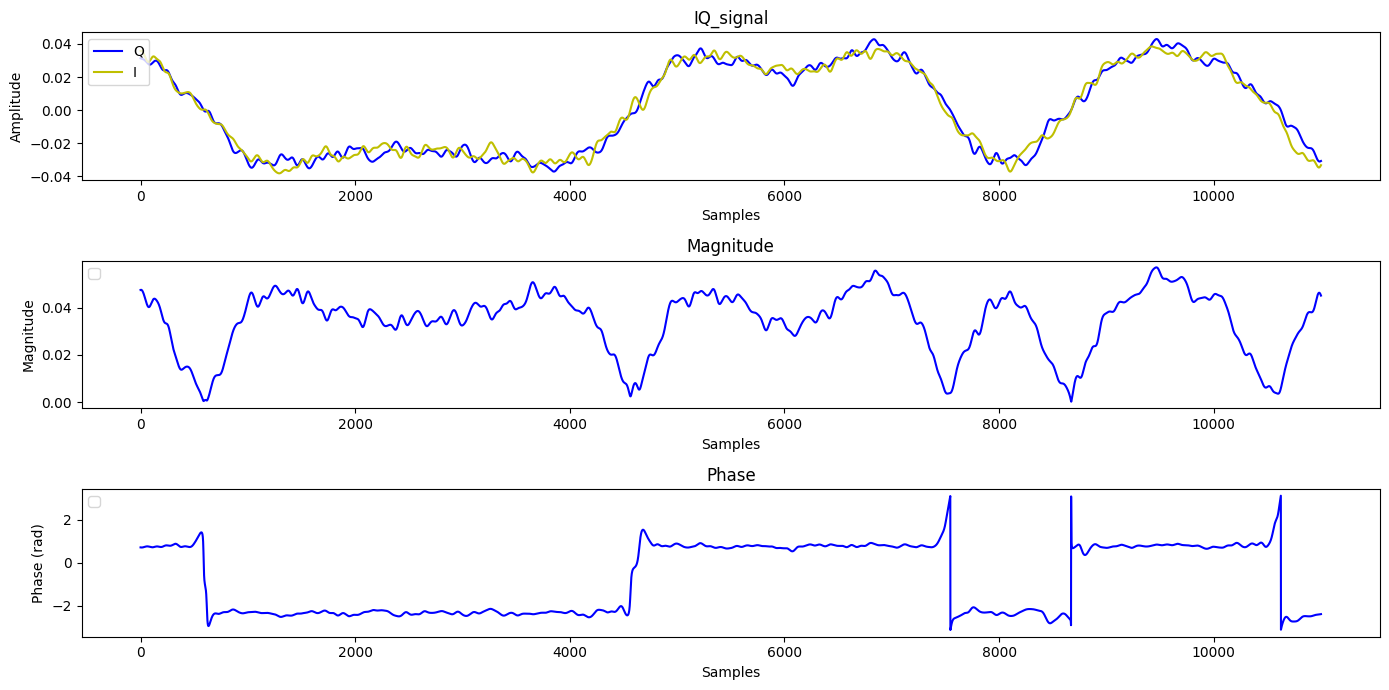

In [3]:
data_base = "../../data/"

data_dir = data_base
suffixes = [f"{i:03d}" for i in range(170)]


sufix = 0
sample = 9999  #0 - 9999
sample_frequency = 25e6 

samples = load_samples(data_dir,f"{sufix:03d}")

i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]




#iq_signal = pd.read_csv('senial.csv')
#q_signal = iq_signal.q.to_numpy()
#i_signal = iq_signal.i.to_numpy()



mag = np.sqrt (q_signal**2 + i_signal**2)
phase = np.arctan2 (q_signal,i_signal)

# Create a figure and subplots
figsize = 7

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(2*figsize, 1*figsize))

ax = axs[0]
# Create the first subplot (2 row, 1 columns, index 1)

ax.plot(q_signal, 'b-', label='Q')  # Red dashed line
ax.plot(i_signal, 'y-', label='I')  # Red dashed line
ax.set_title('IQ_signal')
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
ax.legend(loc='upper left')

# Create the first subplot (2 row, 1 columns, index 1)
ax = axs[1]
ax.plot(mag, 'b-')  # Red dashed line
ax.set_title('Magnitude')
ax.set_xlabel('Samples')
ax.set_ylabel('Magnitude')
ax.legend(loc='upper left')

# Create the second subplot (2 row, 1 columns, index 2)
ax = axs[2]
ax.plot(phase, 'b-')  # Green dots connected by lines
ax.set_title('Phase')
ax.set_xlabel('Samples')
ax.set_ylabel('Phase (rad)')
ax.legend(loc='upper left')



# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()




# 1. Wavelets are present in PyWavelets

In [11]:
wavelet_families = pywt.families(short=False,)
wavelet_families_short = pywt.families()
discrete_mother_wavelets = pywt.wavelist(kind='discrete')
continuous_mother_wavelets = pywt.wavelist(kind='continuous')

print("PyWavelets contains the following families: ")
print(wavelet_families)
print(wavelet_families_short)
print()
print("PyWavelets contains the following Continuous families: ")
print(continuous_mother_wavelets)
print()
print("PyWavelets contains the following Discrete families: ")
print(discrete_mother_wavelets)
print()
for family in pywt.families():
    print("    * The {} family contains: {}".format(family, pywt.wavelist(family)))

PyWavelets contains the following families: 
['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']
['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']

PyWavelets contains the following Continuous families: 
['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']

PyWavelets contains the following Discrete families: 
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11

/home/charlie/.local/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/charlie/.local/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


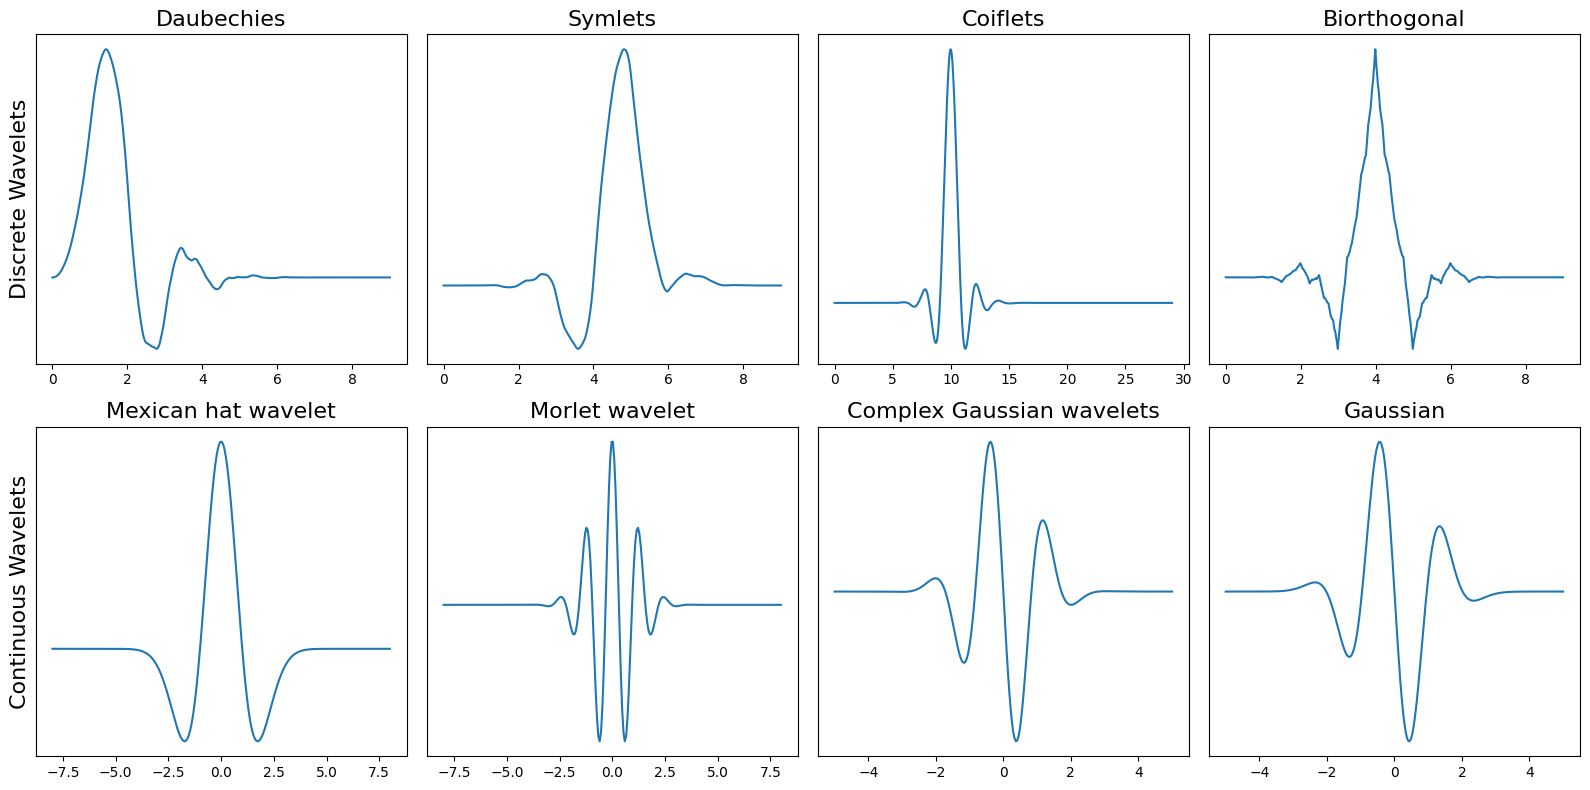

In [12]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.show()

# 2. Visualizing several Discrete and Continuous wavelets

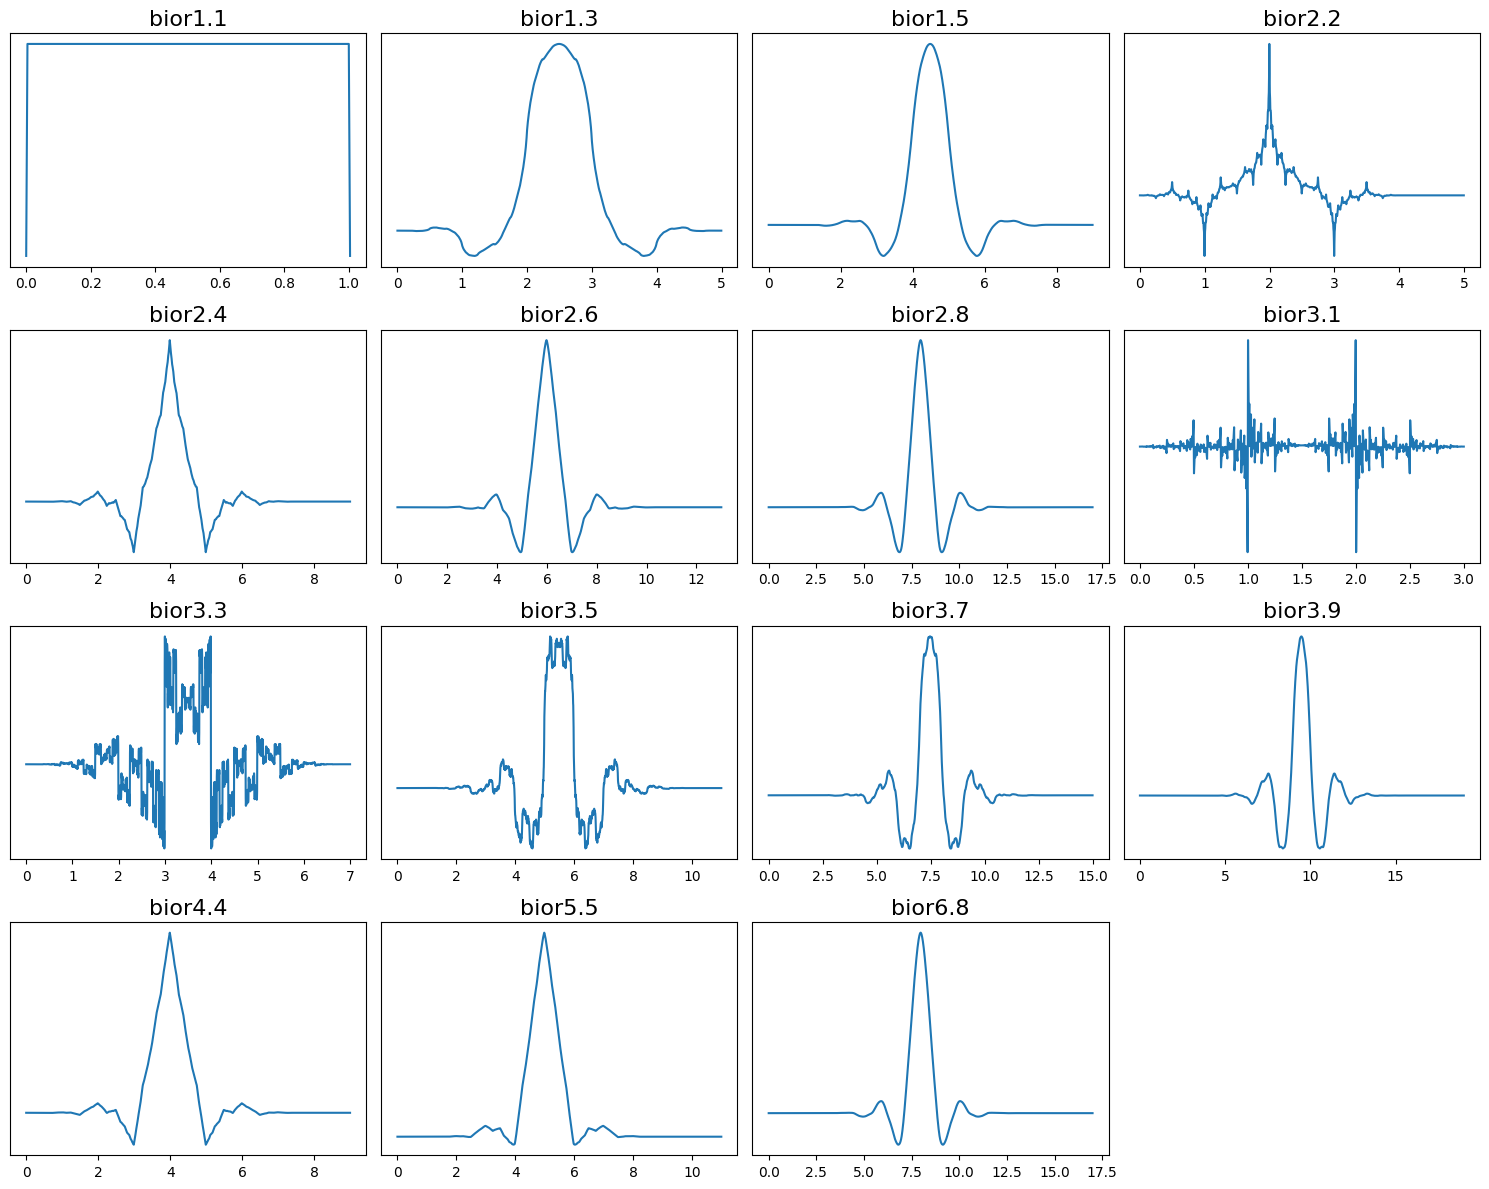

In [14]:
wavelet_familie = 'bior'

wavelet_names = pywt.wavelist(wavelet_familie)


# Determine the number of subplots needed
num_wavelets = len(wavelet_names)
cols = 4
rows = (num_wavelets + cols - 1) // cols

# Create subplots
fig, axarr = plt.subplots(rows, cols, figsize=(15, rows * 3))
axarr = axarr.flatten()

for i, waveletname in enumerate(wavelet_names):
    #row_no = math.ceil(i/cols)
    row_no = math.trunc((i+1)/cols)
    col_no = (i+1) % cols

    wavelet_name = wavelet_names[i]
    discrete_wavelets = pywt.wavelist(kind='discrete')
    discrete = wavelet_name in discrete_wavelets
    
    if discrete:
        func = pywt.Wavelet
        wavelet = func(waveletname)
        _ = wavelet.wavefun()
        wavelet_function = _[0]
        x_values = _[-1]
    else:
        func = pywt.ContinuousWavelet
        wavelet = func(waveletname)
        wavelet_function, x_values = wavelet.wavefun()

    
    family_name = wavelet.family_name
    biorthogonal = wavelet.biorthogonal
    orthogonal = wavelet.orthogonal
    symmetry = wavelet.symmetry

    axarr[i].set_title("{}".format(wavelet_name), fontsize=16)
    axarr[i].plot(x_values, wavelet_function)
    axarr[i].set_yticks([])
    axarr[i].set_yticklabels([])


for j in range(len(wavelet_names),len(axarr)):
    fig.delaxes(axarr[j])

     
plt.tight_layout()
plt.show()




# 3. Visualizing how the wavelet form depends on the order and decomposition level

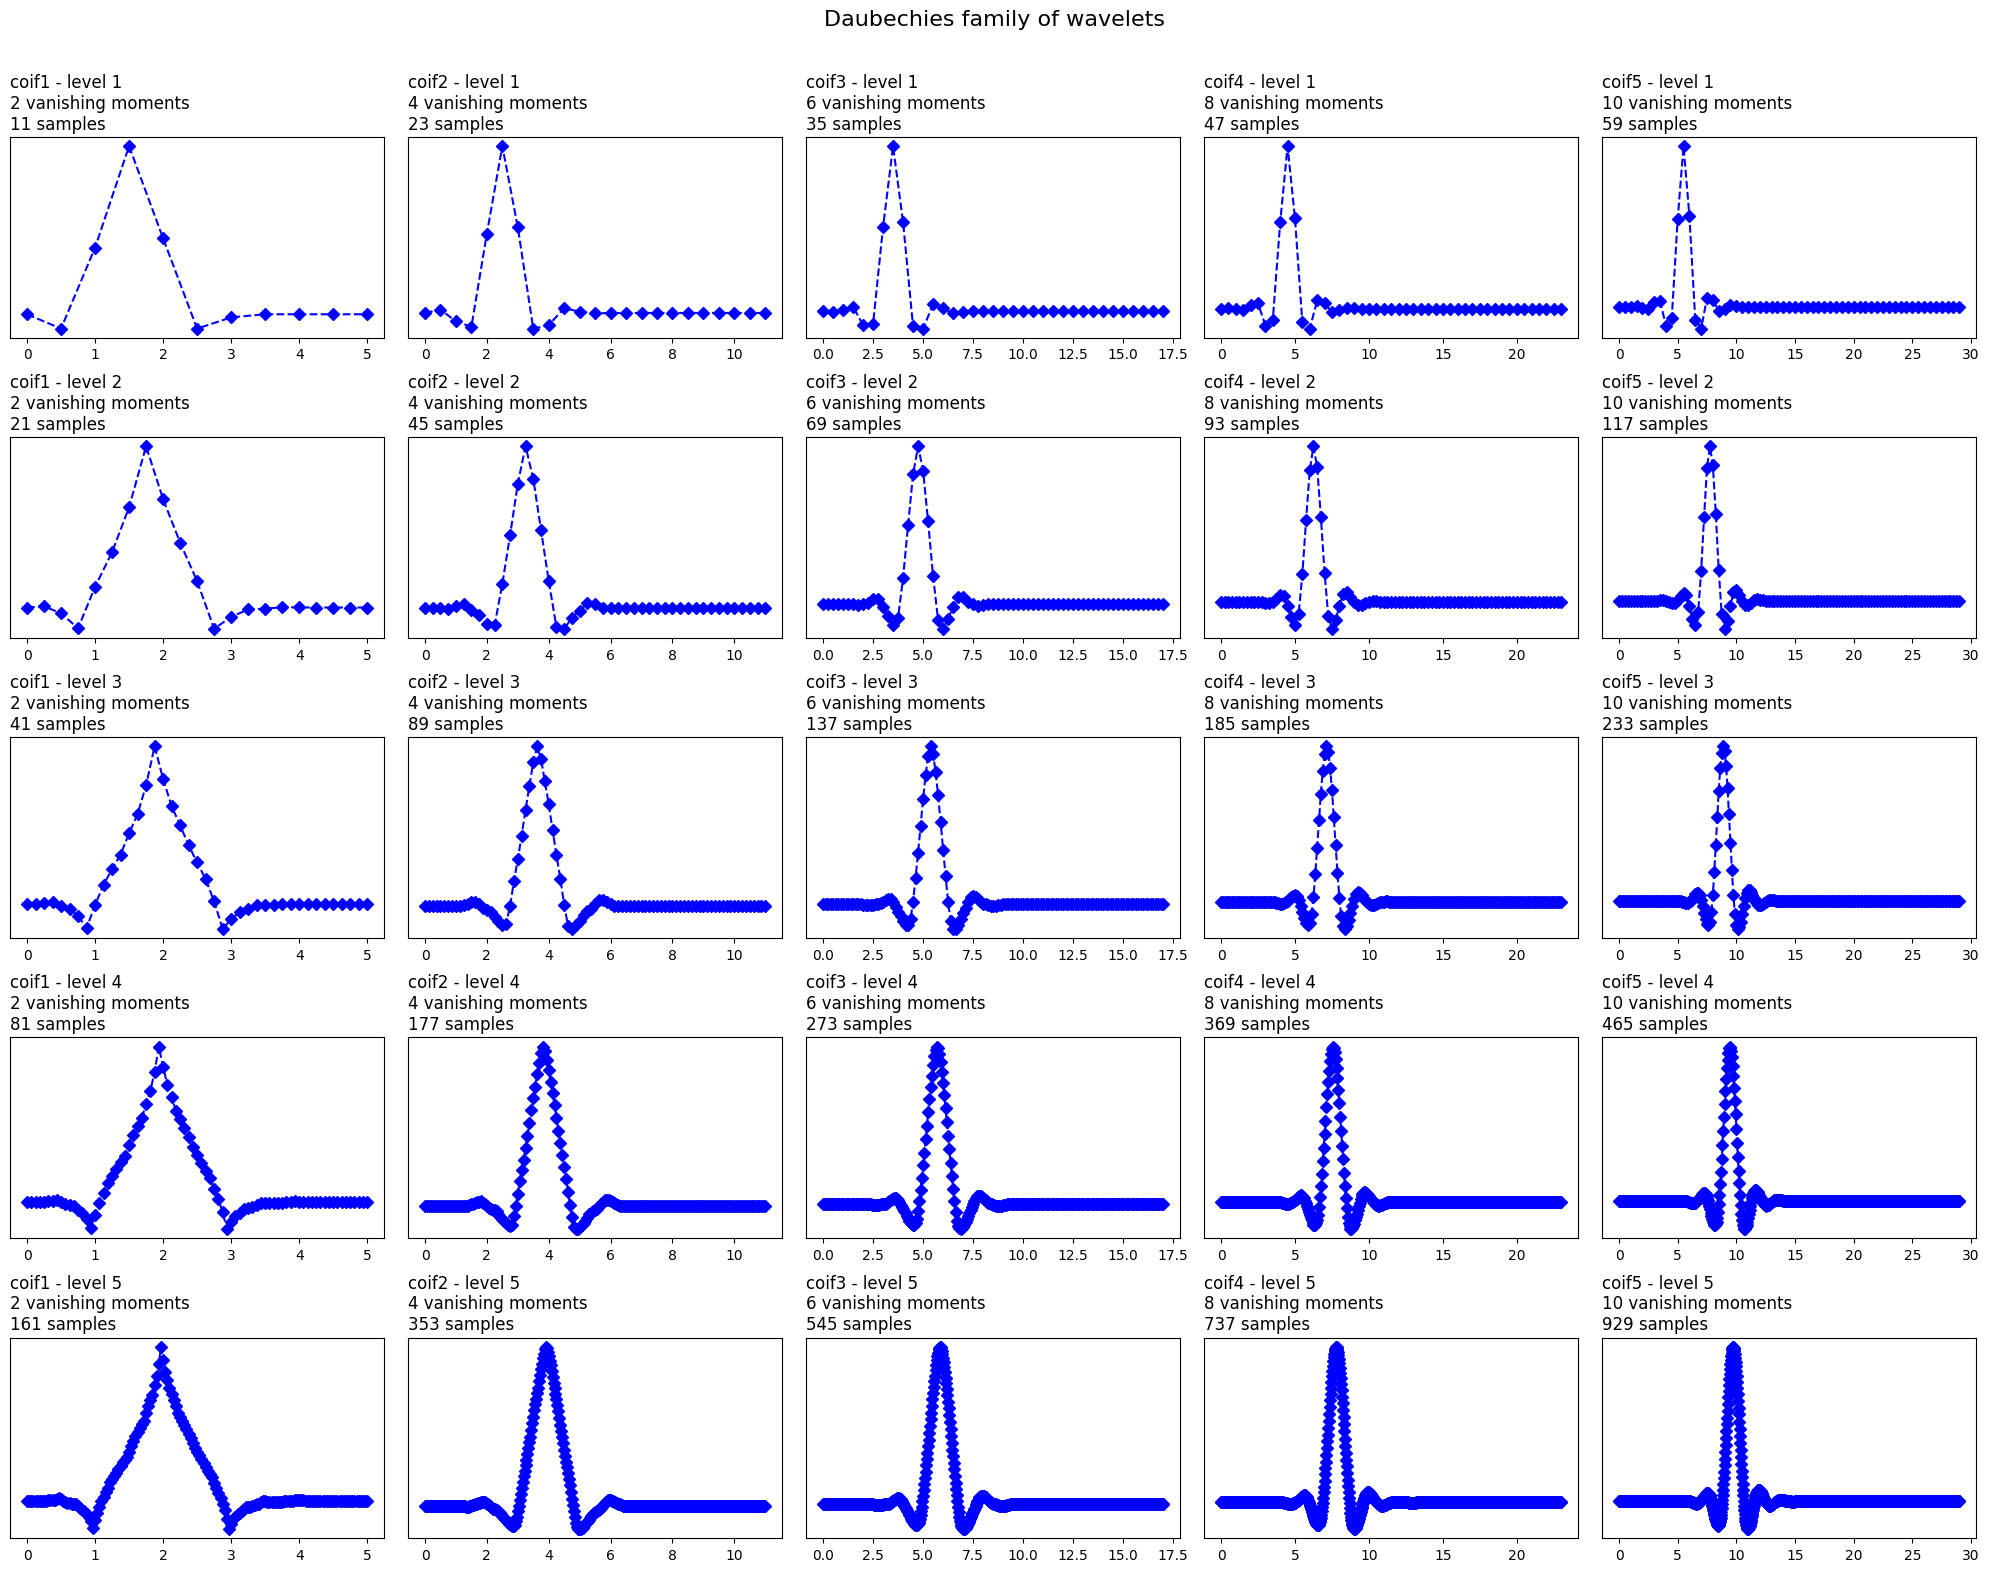

In [15]:
fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(20,16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)

db_wavelets = pywt.wavelist('coif')[:5]

for col_no, waveletname in enumerate(db_wavelets):
    wavelet = pywt.Wavelet(waveletname)
    no_moments = wavelet.vanishing_moments_psi
    family_name = wavelet.family_name
    for row_no, level in enumerate(range(1,6)):
        wavelet_function, scaling_function, x_values = wavelet.wavefun(level = level)
        axarr[row_no, col_no].set_title("{} - level {}\n{} vanishing moments\n{} samples".format(
            waveletname, level, no_moments, len(x_values)), loc='left')
        axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
        plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# 4.A Using the discrete wavelet transform for the decomposition of a signal into the frequency sub-bands
(and reconstrucing it again)

0.0


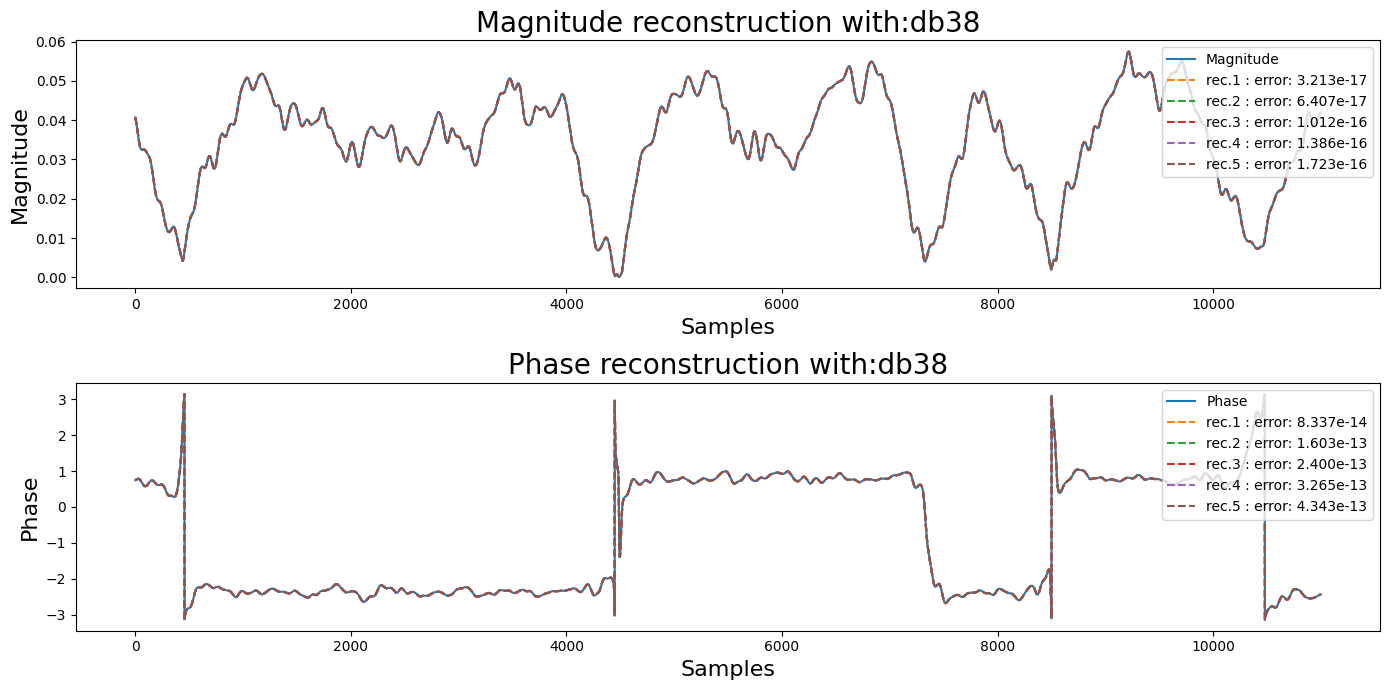

In [16]:
data_dir = "../../data/"
suffixes = [f"{i:03d}" for i in range(170)]

sufix = 1
sample = 2  #0 - 9999
sample_frequency = 25e6 

samples = load_samples(data_dir,f"{sufix:03d}")

i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]
iq_signal = np.array(i_signal + 1J*q_signal, dtype=complex)

mag = np.sqrt (q_signal**2 + i_signal**2)
phase = np.arctan2 (q_signal,i_signal)


suffix = 38
short_name_wavelet='db'
wave = short_name_wavelet + str(suffix)
mode = 'smooth' # zero  constant  symmetric  reflect  periodic  smooth  antisymmetric  antireflect  periodization


def discrete_wavelet(signal, wave, mode):

    (cA1, cD1) = pywt.dwt(signal, wave, mode)
    (cA2, cD2) = pywt.dwt(cA1, wave, mode)
    (cA3, cD3) = pywt.dwt(cA2, wave, mode)
    (cA4, cD4) = pywt.dwt(cA3, wave, mode)
    (cA5, cD5) = pywt.dwt(cA4, wave, mode)

    coefficients_level1 = [cA1, cD1]
    coefficients_level2 = [cA2, cD2, cD1]
    coefficients_level3 = [cA3, cD3, cD2, cD1]
    coefficients_level4 = [cA4, cD4, cD3, cD2, cD1]
    coefficients_level5 = [cA5, cD5, cD4, cD3, cD2, cD1]

    reconstructed_signal_level1 = pywt.waverec(coefficients_level1, wave, mode)
    reconstructed_signal_level2 = pywt.waverec(coefficients_level2, wave, mode)
    reconstructed_signal_level3 = pywt.waverec(coefficients_level3, wave, mode)
    reconstructed_signal_level4 = pywt.waverec(coefficients_level4, wave, mode)
    reconstructed_signal_level5 = pywt.waverec(coefficients_level5, wave, mode)

    return reconstructed_signal_level1, reconstructed_signal_level2, reconstructed_signal_level3, reconstructed_signal_level4, reconstructed_signal_level5

#mag = q_signal
#phase = i_signal

reconstructed_signal_level01, reconstructed_signal_level02, reconstructed_signal_level03, reconstructed_signal_level04, reconstructed_signal_level05 = discrete_wavelet(mag, wave, mode)
reconstructed_signal_level11, reconstructed_signal_level12, reconstructed_signal_level13, reconstructed_signal_level14, reconstructed_signal_level15 = discrete_wavelet(phase, wave, mode)

mse01 = mean_squared_error(mag, reconstructed_signal_level01)
mse02 = mean_squared_error(mag, reconstructed_signal_level02)
mse03 = mean_squared_error(mag, reconstructed_signal_level03)
mse04 = mean_squared_error(mag, reconstructed_signal_level04)
mse05 = mean_squared_error(mag, reconstructed_signal_level05)

mse11 = mean_squared_error(phase, reconstructed_signal_level11)
mse12 = mean_squared_error(phase, reconstructed_signal_level12)
mse13 = mean_squared_error(phase, reconstructed_signal_level13)
mse14 = mean_squared_error(phase, reconstructed_signal_level14)
mse15 = mean_squared_error(phase, reconstructed_signal_level15)

mse = np.mean((mag - reconstructed_signal_level01) ** 2)
print(mse-mse01)



figsize = 7

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(2*figsize, 1*figsize))
ax = axs[0]
ax.plot(mag, label='Magnitude')
ax.plot(reconstructed_signal_level01, label=f"rec.1 : error: {mse01:0.3e}", linestyle='--')
ax.plot(reconstructed_signal_level02, label=f"rec.2 : error: {mse02:0.3e}", linestyle='--')
ax.plot(reconstructed_signal_level03, label=f"rec.3 : error: {mse03:0.3e}", linestyle='--')
ax.plot(reconstructed_signal_level04, label=f"rec.4 : error: {mse04:0.3e}", linestyle='--')
ax.plot(reconstructed_signal_level05, label=f"rec.5 : error: {mse05:0.3e}", linestyle='--')
ax.legend(loc='upper right')
ax.set_title('Magnitude reconstruction with:'+ wave, fontsize=20)
ax.set_xlabel('Samples', fontsize=16)
ax.set_ylabel('Magnitude', fontsize=16)
ax = axs[1]
ax.plot(phase, label='Phase')
ax.plot(reconstructed_signal_level11, label=f"rec.1 : error: {mse11:0.3e}", linestyle='--')
ax.plot(reconstructed_signal_level12, label=f"rec.2 : error: {mse12:0.3e}", linestyle='--')
ax.plot(reconstructed_signal_level13, label=f"rec.3 : error: {mse13:0.3e}", linestyle='--')
ax.plot(reconstructed_signal_level14, label=f"rec.4 : error: {mse14:0.3e}", linestyle='--')
ax.plot(reconstructed_signal_level15, label=f"rec.5 : error: {mse15:0.3e}", linestyle='--')
ax.legend(loc='upper right')
ax.set_title('Phase reconstruction with:'+ wave, fontsize=20)
ax.set_xlabel('Samples', fontsize=16)
ax.set_ylabel('Phase', fontsize=16)
# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# 5. Reconstrucing a signal with only one level of coefficients


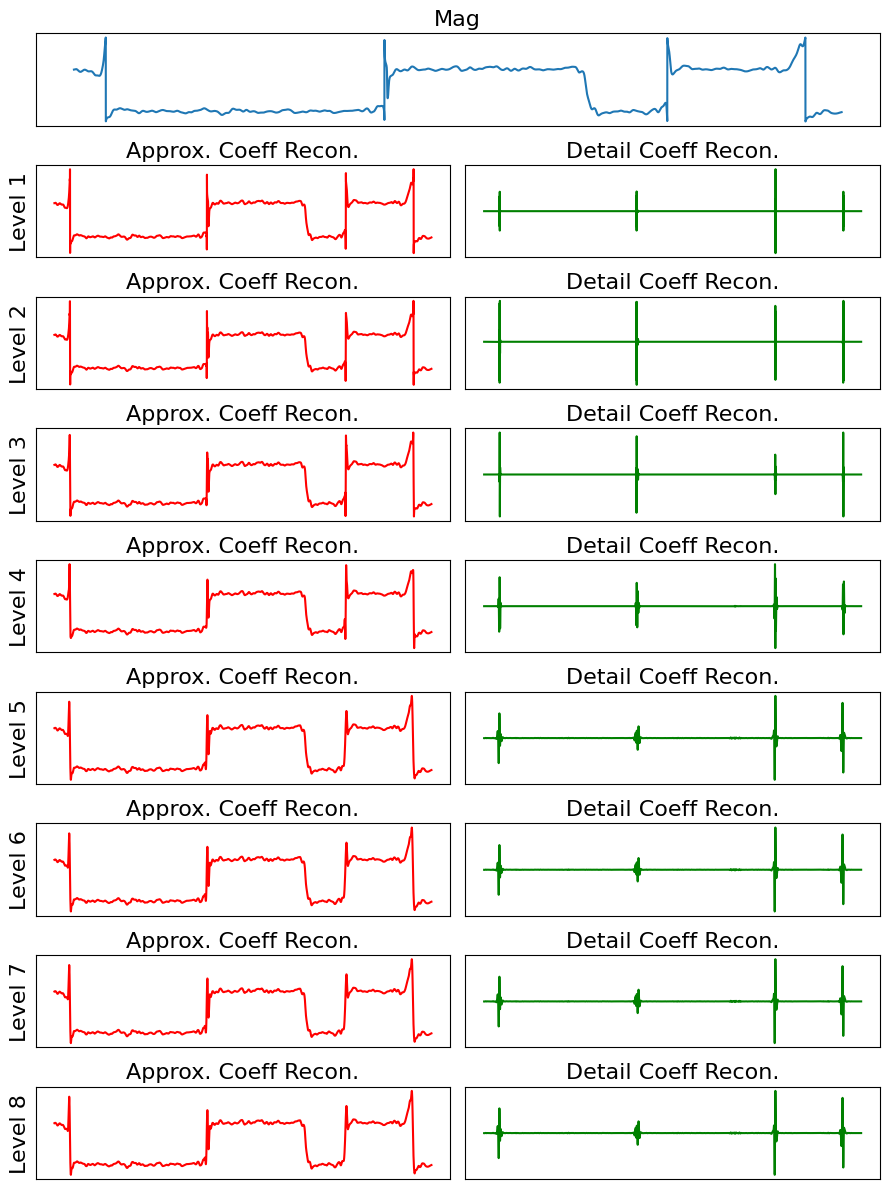

In [17]:
fig = plt.figure(figsize=(9,12))
spec = gridspec.GridSpec(ncols=2, nrows=9)
ax0 = fig.add_subplot(spec[0, 0:2])
ax1a = fig.add_subplot(spec[1, 0])
ax1b = fig.add_subplot(spec[1, 1])
ax2a = fig.add_subplot(spec[2, 0])
ax2b = fig.add_subplot(spec[2, 1])
ax3a = fig.add_subplot(spec[3, 0])
ax3b = fig.add_subplot(spec[3, 1])
ax4a = fig.add_subplot(spec[4, 0])
ax4b = fig.add_subplot(spec[4, 1])
ax5a = fig.add_subplot(spec[5, 0])
ax5b = fig.add_subplot(spec[5, 1])
ax6a = fig.add_subplot(spec[6, 0])
ax6b = fig.add_subplot(spec[6, 1])
ax7a = fig.add_subplot(spec[7, 0])
ax7b = fig.add_subplot(spec[7, 1])
ax8a = fig.add_subplot(spec[8, 0])
ax8b = fig.add_subplot(spec[8, 1])
axarr = np.array([[ax1a, ax1b],[ax2a, ax2b],[ax3a, ax3b],[ax4a, ax4b],[ax5a, ax5b], [ax6a, ax6b],[ax7a, ax7b],[ax8a, ax8b]])


data_dir = "../../data/"
suffixes = [f"{i:03d}" for i in range(170)]

sufix = 1
sample = 2  #0 - 9999
sample_frequency = 25e6 

samples = load_samples(data_dir,f"{sufix:03d}")

i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]

mag = np.sqrt (q_signal**2 + i_signal**2)
phase = np.arctan2 (q_signal,i_signal)


suffix = 3.5
short_name_wavelet='bior'
wave = short_name_wavelet + str(suffix)

signal = phase
# First we reconstruct a signal using pywt.wavedec() as we have also done at #4.2
coefficients_level1 = pywt.wavedec(signal, wave, 'smooth', level=1)
coefficients_level2 = pywt.wavedec(signal, wave, 'smooth', level=2)
coefficients_level3 = pywt.wavedec(signal, wave, 'smooth', level=3)
coefficients_level4 = pywt.wavedec(signal, wave, 'smooth', level=4)
coefficients_level5 = pywt.wavedec(signal, wave, 'smooth', level=5)
coefficients_level6 = pywt.wavedec(signal, wave, 'smooth', level=6)
coefficients_level7 = pywt.wavedec(signal, wave, 'smooth', level=7)
coefficients_level8 = pywt.wavedec(signal, wave, 'smooth', level=8)

# pywt.wavedec() returns a list of coefficients. Below we assign these list of coefficients to variables explicitely.
[cA1_l1, cD1_l1] = coefficients_level1
[cA2_l2, cD2_l2, cD1_l2] = coefficients_level2
[cA3_l3, cD3_l3, cD2_l3, cD1_l3] = coefficients_level3
[cA4_l4, cD4_l4, cD3_l4, cD2_l4, cD1_l4] = coefficients_level4
[cA5_l5, cD5_l5, cD4_l5, cD3_l5, cD2_l5, cD1_l5] = coefficients_level5
[cA6_l6, cD6_l6, cD5_l6, cD4_l6, cD3_l6, cD2_l6, cD1_l6] = coefficients_level6
[cA7_l7, cD7_l7, cA6_l7, cD5_l7, cD4_l7, cD3_l7, cD2_l7, cD1_l7] = coefficients_level7
[cA8_l8, cD8_l8, cD7_l8, cD6_l8, cD5_l8, cD4_l8, cD3_l8, cD2_l8, cD1_l8] = coefficients_level8

# Since the the list of coefficients have been assigned explicitely to variables, we can set a few of them to zero.
approx_coeff_level1_only = [cA1_l1, None]
detail_coeff_level1_only = [None, cD1_l1]

approx_coeff_level2_only = [cA2_l2, None, None]
detail_coeff_level2_only = [None, cD2_l2, None]

approx_coeff_level3_only = [cA3_l3, None, None, None]
detail_coeff_level3_only = [None, cD3_l3, None, None]

approx_coeff_level4_only = [cA4_l4, None, None, None, None]
detail_coeff_level4_only = [None, cD4_l4, None, None, None]

approx_coeff_level5_only = [cA5_l5, None, None, None, None, None]
detail_coeff_level5_only = [None, cD5_l5, None, None, None, None]

approx_coeff_level6_only = [cA6_l6, None, None, None, None, None, None]
detail_coeff_level6_only = [None, cD6_l6, None, None, None, None, None]

approx_coeff_level7_only = [cA7_l7, None, None, None, None, None, None, None]
detail_coeff_level7_only = [None, cD7_l7, None, None, None, None, None, None]

approx_coeff_level8_only = [cA8_l8, None, None, None, None, None, None, None, None]
detail_coeff_level8_only = [None, cD8_l8, None, None, None, None, None, None, None]
#detail_coeff_level5_only = [cA5_l5, cD5_l5, cD4_l4, cD3_l3, cD2_l2, cD1_l1]


# By reconstrucing the signal back from only one set of coefficients, we can see how 
# the frequency-sub band for that specific set of coefficient looks like
rec_signal_cA_level1 = pywt.waverec(approx_coeff_level1_only, wave, 'smooth')
rec_signal_cD_level1 = pywt.waverec(detail_coeff_level1_only, wave, 'smooth')

rec_signal_cA_level2 = pywt.waverec(approx_coeff_level2_only, wave, 'smooth')
rec_signal_cD_level2 = pywt.waverec(detail_coeff_level2_only, wave, 'smooth')

rec_signal_cA_level3 = pywt.waverec(approx_coeff_level3_only, wave, 'smooth')
rec_signal_cD_level3 = pywt.waverec(detail_coeff_level3_only, wave, 'smooth')

rec_signal_cA_level4 = pywt.waverec(approx_coeff_level4_only, wave, 'smooth')
rec_signal_cD_level4 = pywt.waverec(detail_coeff_level4_only, wave, 'smooth')

rec_signal_cA_level5 = pywt.waverec(approx_coeff_level5_only, wave, 'smooth')
rec_signal_cD_level5 = pywt.waverec(detail_coeff_level5_only, wave, 'smooth')

rec_signal_cA_level6 = pywt.waverec(approx_coeff_level5_only, wave, 'smooth')
rec_signal_cD_level6 = pywt.waverec(detail_coeff_level5_only, wave, 'smooth')

rec_signal_cA_level7 = pywt.waverec(approx_coeff_level5_only, wave, 'smooth')
rec_signal_cD_level7 = pywt.waverec(detail_coeff_level5_only, wave, 'smooth')

rec_signal_cA_level8 = pywt.waverec(approx_coeff_level5_only, wave, 'smooth')
rec_signal_cD_level8 = pywt.waverec(detail_coeff_level5_only, wave, 'smooth')


'''
mse01 = mean_squared_error(mag, rec_signal_cA_level1)
mse02 = mean_squared_error(mag, rec_signal_cA_level2)
mse03 = mean_squared_error(mag, rec_signal_cA_level3)
mse04 = mean_squared_error(mag, rec_signal_cA_level4)
mse05 = mean_squared_error(mag, rec_signal_cA_level5)
'''

ax0.set_title("Mag", fontsize=16)
ax0.plot(signal)
ax0.set_xticks([])
ax0.set_yticks([])
ax1a.plot(rec_signal_cA_level1,label=f"error: {mse01:0.3e}", color='red')
ax1b.plot(rec_signal_cD_level1, color='green')
ax2a.plot(rec_signal_cA_level2,label=f"error: {mse02:0.3e}", color='red')
ax2b.plot(rec_signal_cD_level2, color='green')
ax3a.plot(rec_signal_cA_level3,label=f"error: {mse03:0.3e}", color='red')
ax3b.plot(rec_signal_cD_level3, color='green')
ax4a.plot(rec_signal_cA_level4,label=f"error: {mse04:0.3e}", color='red')
ax4b.plot(rec_signal_cD_level4, color='green')
ax5a.plot(rec_signal_cA_level5,label=f"error: {mse05:0.3e}", color='red')
ax5b.plot(rec_signal_cD_level5, color='green')
ax6a.plot(rec_signal_cA_level6,label=f"error: {mse05:0.3e}", color='red')
ax6b.plot(rec_signal_cD_level6, color='green')
ax7a.plot(rec_signal_cA_level7,label=f"error: {mse05:0.3e}", color='red')
ax7b.plot(rec_signal_cD_level7, color='green')
ax8a.plot(rec_signal_cA_level8,label=f"error: {mse05:0.3e}", color='red')
ax8b.plot(rec_signal_cD_level8, color='green')

for ii in range(0,8):
    axarr[ii,0].set_xticks([])
    axarr[ii,0].set_yticks([])
    axarr[ii,1].set_xticks([])
    axarr[ii,1].set_yticks([])
    axarr[ii,0].set_title("Approx. Coeff Recon.", fontsize=16)
    axarr[ii,1].set_title("Detail Coeff Recon.", fontsize=16)
    axarr[ii,0].set_ylabel("Level {}".format(ii+1), fontsize=16)
plt.tight_layout()
plt.show()

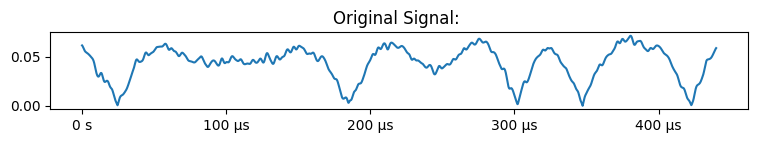

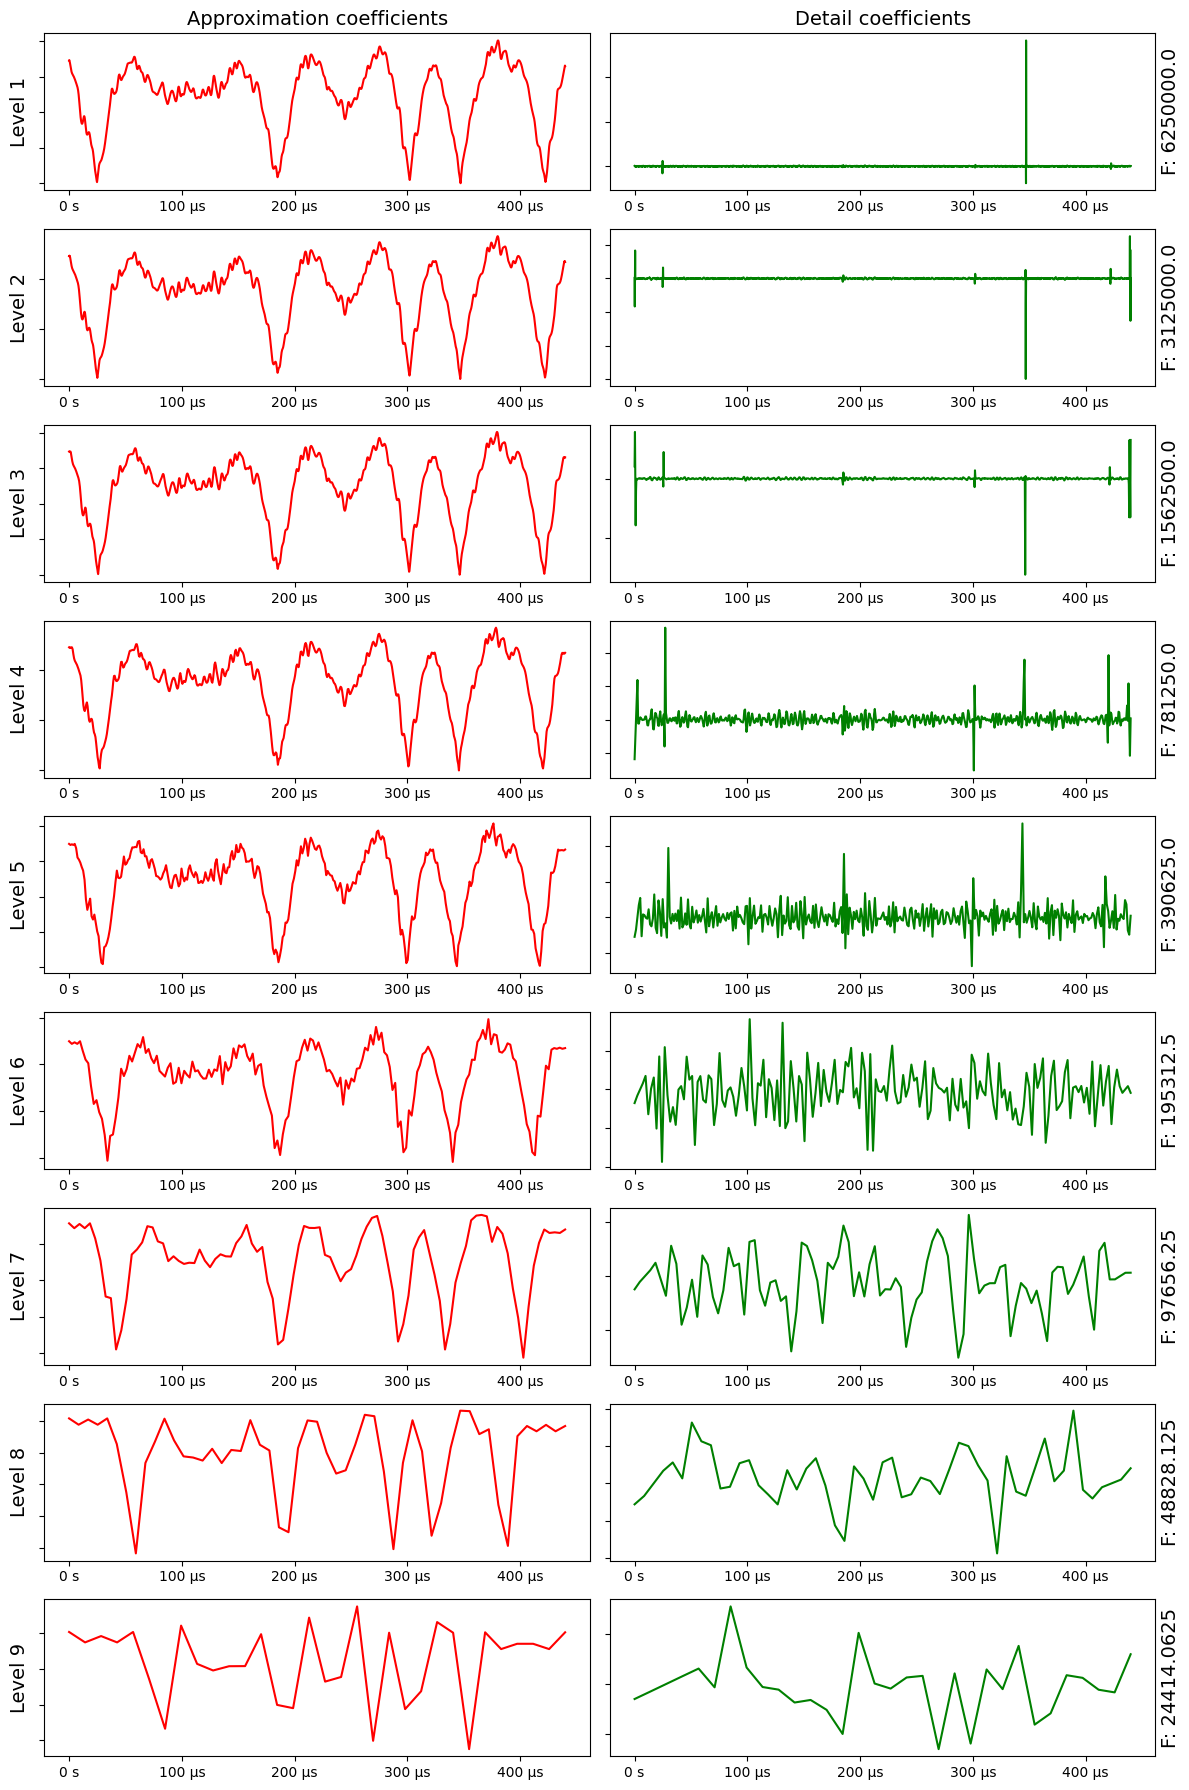

'\nfs = 25e6\nfig, axarr = plt.subplots(nrows=split, ncols=2, figsize=(12,split*2))\nfor ii in range(split):\n    (data, coeff_d) = pywt.dwt(data, waveletname)\n    fft_freqs_a, fft_values_a, power_spectrum_a, magnitud_a = get_fft_values(data,f_s=fs/(2**(ii+1)), pos = True)\n    fft_freqs_c, fft_values_c, power_spectrum_c, magnitud_c = get_fft_values(coeff_d,f_s=fs/(2**(ii+1)), pos = True)\n    axarr[ii, 0].plot(fft_freqs_a, magnitud_a, \'r\')                                                 #Approximation coefficients  0\n    axarr[ii, 1].plot(fft_freqs_c, magnitud_c, \'g\')                                              #Detail coefficients         1\n    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90) #Print on the plot the level\n    axarr[ii, 0].set_yticklabels([])                                             #Shows the levels   \n    axarr[ii, 1].semilogx()\n    axarr[ii, 0].semilogx()\n    if ii == 0:\n        axarr[ii, 0].set_title("Approx FFT coefficie

In [18]:
#iq_signal = pd.read_csv('senial.csv')

#q_signal = iq_signal.q.to_numpy()
#i_signal = iq_signal.i.to_numpy()

data_dir = "../../data/"

sufix = 1
sample = 1  #0 - 9999
fs = 25e6 

samples = load_samples(data_dir,f"{sufix:03d}")

i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]

iq_signal = np.array(i_signal + 1J*q_signal, dtype=complex)

mag = np.sqrt (q_signal**2 + i_signal**2)
phase = np.arctan2 (q_signal,i_signal)

data = mag
waveletname = 'bior3.5'

time = np.arange(0, len(data)) * (1/fs)

fig, ax = plt.subplots(figsize=(9,1))
ax.set_title("Original Signal: ")
ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
ax.plot(time,data)
plt.show()
    

split = 9
 
fig, axarr = plt.subplots(nrows=split, ncols=2, figsize=(12,split*2))

for ii in range(split):
    
    (data, coeff_d) = pywt.dwt(data, waveletname)
    time_data = np.linspace(0, time[-1], len(data))
    time_coeff = np.linspace(0,  time[-1], len(coeff_d))
    axarr[ii, 0].plot(time_data, data, 'r')                                                 #Approximation coefficients  0
    axarr[ii, 1].plot(time_coeff, coeff_d, 'g')                                              #Detail coefficients         1
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90) #Print on the plot the level
    axarr[ii, 1].set_ylabel("F: {}".format(fs/2**(ii+1+1)), fontsize=14, rotation=90)
    axarr[ii, 1].yaxis.set_label_position("right")    
    axarr[ii, 0].set_yticklabels([])                                             #Shows the levels   
    axarr[ii, 0].xaxis.set_major_formatter(EngFormatter(unit='s'))
    axarr[ii, 1].xaxis.set_major_formatter(EngFormatter(unit='s'))
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)        #Approximation coefficients  0
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)               #Detail coefficients         1
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

'''
fs = 25e6
fig, axarr = plt.subplots(nrows=split, ncols=2, figsize=(12,split*2))
for ii in range(split):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    fft_freqs_a, fft_values_a, power_spectrum_a, magnitud_a = get_fft_values(data,f_s=fs/(2**(ii+1)), pos = True)
    fft_freqs_c, fft_values_c, power_spectrum_c, magnitud_c = get_fft_values(coeff_d,f_s=fs/(2**(ii+1)), pos = True)
    axarr[ii, 0].plot(fft_freqs_a, magnitud_a, 'r')                                                 #Approximation coefficients  0
    axarr[ii, 1].plot(fft_freqs_c, magnitud_c, 'g')                                              #Detail coefficients         1
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90) #Print on the plot the level
    axarr[ii, 0].set_yticklabels([])                                             #Shows the levels   
    axarr[ii, 1].semilogx()
    axarr[ii, 0].semilogx()
    if ii == 0:
        axarr[ii, 0].set_title("Approx FFT coefficients", fontsize=14)        #Approximation coefficients  0
        axarr[ii, 1].set_title("Detail FFT coefficients", fontsize=14)               #Detail coefficients         1
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()
'''

example of PSD

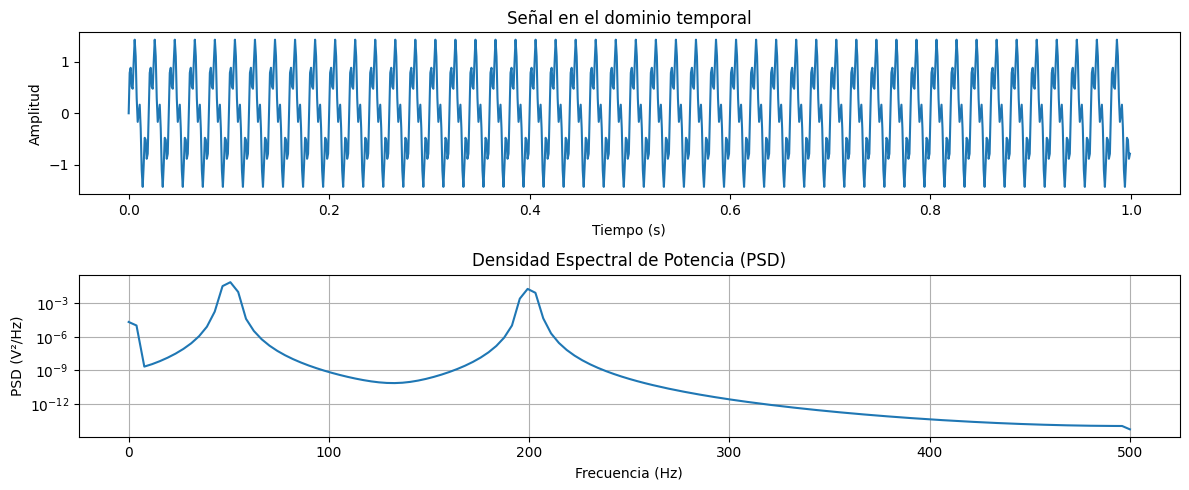

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Parámetros de la señal
fs = 1000  # Frecuencia de muestreo (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Vector de tiempo (1 segundo)
f1, f2 = 50, 200  # Frecuencias de la señal (Hz)
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t) # Señal compuesta

# Calcular la PSD usando el método de Welch
f, Pxx = welch(signal, fs, nperseg=256)

# Graficar la señal en dominio temporal
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title("Señal en el dominio temporal")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

# Graficar la Densidad Espectral de Potencia (PSD)
plt.subplot(2, 1, 2)
plt.semilogy(f, Pxx)  # Escala logarítmica para mejor visualización
plt.title("Densidad Espectral de Potencia (PSD)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD (V²/Hz)")
plt.grid()

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Parámetros de la señal
fs = 1000  # Frecuencia de muestreo (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 segundo de señal
center_freq = 50  # Frecuencia central de interés (Hz)
bandwidth = 40  # Ancho de banda total (Hz) -> 30-70 Hz

# Generar señales de diferentes "dispositivos"
def generate_signal(freqs, noise_level=0.1):
    signal = sum(np.sin(2 * np.pi * f * t) for f in freqs)
    noise = noise_level * np.random.randn(len(t))  # Ruido blanco
    return signal + noise

# Simular señales de 3 dispositivos con diferentes firmas de frecuencia
device_signals = {
    0: generate_signal([50, 150]),  # Dispositivo 1
    1: generate_signal([70, 200]),  # Dispositivo 2
    2: generate_signal([90, 250])   # Dispositivo 3
}

# Extraer características de la PSD en la banda de interés
def extract_band_psd_features(signal, center_freq, bandwidth):
    f, Pxx = welch(signal, fs, nperseg=256)
    
    # Seleccionar solo la banda de interés
    band_mask = (f >= (center_freq - bandwidth / 2)) & (f <= (center_freq + bandwidth / 2))
    Pxx_band = Pxx[band_mask]

    return [
        np.sum(Pxx_band),  # Energía en la banda seleccionada
        np.mean(Pxx_band),  # Media de la PSD en la banda
        np.var(Pxx_band)    # Varianza en la banda
    ]

# Construir dataset
X, y = [], []
for label, signal in device_signals.items():
    for _ in range(50):  # Generamos 50 muestras por dispositivo
        noisy_signal = signal + 0.05 * np.random.randn(len(signal))  # Agregar ruido
        features = extract_band_psd_features(noisy_signal, center_freq, bandwidth)
        X.append(features)
        y.append(label)

X, y = np.array(X), np.array(y)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 100.00%


Precisión del modelo: 91.67%


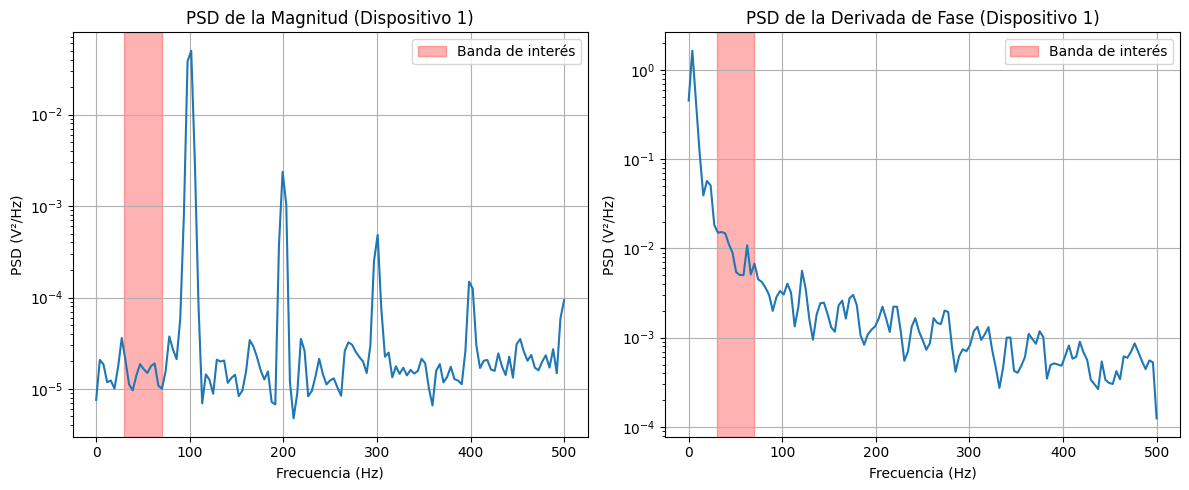

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Parámetros de la señal
fs = 1000  # Frecuencia de muestreo (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 segundo de señal
center_freq = 50  # Frecuencia central de interés (Hz)
bandwidth = 40  # Ancho de banda total (Hz) -> 30-70 Hz

# Generar señales IQ con diferentes firmas de frecuencia
def generate_iq_signal(freqs, noise_level=0.1):
    I = sum(np.sin(2 * np.pi * f * t) for f in freqs)  # Componente en fase (I)
    Q = sum(np.cos(2 * np.pi * f * t) for f in freqs)  # Componente en cuadratura (Q)
    noise_I = noise_level * np.random.randn(len(t))
    noise_Q = noise_level * np.random.randn(len(t))
    return (I + noise_I) + 1j * (Q + noise_Q)  # Señal IQ compleja

# Simular señales IQ de 3 dispositivos distintos
device_signals = {
    0: generate_iq_signal([50, 150]),  # Dispositivo 1
    1: generate_iq_signal([70, 200]),  # Dispositivo 2
    2: generate_iq_signal([90, 250])   # Dispositivo 3
}

# Extraer características de la PSD en la banda de interés (Magnitud y Fase)
def extract_psd_phase_features(iq_signal, center_freq, bandwidth):
    # Obtener Magnitud y Fase de la señal IQ
    magnitude = np.abs(iq_signal)
    phase = np.angle(iq_signal)  # Fase en radianes
    
    # Derivada de la fase (diferencia de fase entre muestras consecutivas)
    phase_diff = np.diff(phase)  

    # Corregir discontinuidades de fase en [-pi, pi]
    phase_diff = np.unwrap(phase_diff)

    # Calcular PSD de la magnitud
    f, Pxx_mag = welch(magnitude, fs, nperseg=256)
    
    # Calcular PSD de la derivada de la fase
    f_phase, Pxx_phase = welch(phase_diff, fs, nperseg=256)
    
    # Seleccionar solo la banda de interés
    band_mask = (f >= (center_freq - bandwidth / 2)) & (f <= (center_freq + bandwidth / 2))
    Pxx_mag_band = Pxx_mag[band_mask]
    Pxx_phase_band = Pxx_phase[band_mask]
    
    # Características de la magnitud
    mag_features = [
        np.sum(Pxx_mag_band),  # Energía en la banda
        np.mean(Pxx_mag_band),  # Media de la PSD
        np.var(Pxx_mag_band)    # Varianza de la PSD
    ]
    
    # Características de la fase
    phase_features = [
        np.sum(Pxx_phase_band),  # Energía en la banda de la derivada de fase
        np.mean(Pxx_phase_band),  # Media de la PSD de la fase
        np.var(Pxx_phase_band)    # Varianza de la PSD de la fase
    ]
    
    return mag_features + phase_features

# Construir dataset
X, y = [], []
for label, iq_signal in device_signals.items():
    for _ in range(1000):  # Generamos 50 muestras por dispositivo
        noisy_iq_signal = iq_signal + 0.05 * (np.random.randn(len(iq_signal)) + 1j * np.random.randn(len(iq_signal)))  # Ruido adicional
        features = extract_psd_phase_features(noisy_iq_signal, center_freq, bandwidth)
        X.append(features)
        y.append(label)

X, y = np.array(X), np.array(y)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Graficar la PSD de la magnitud y fase
plt.figure(figsize=(12, 5))

# Graficar PSD de la magnitud
plt.subplot(1, 2, 1)
f, Pxx_mag = welch(np.abs(device_signals[0]), fs, nperseg=256)
plt.semilogy(f, Pxx_mag)
plt.axvspan(center_freq - bandwidth / 2, center_freq + bandwidth / 2, color='red', alpha=0.3, label="Banda de interés")
plt.title("PSD de la Magnitud (Dispositivo 1)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD (V²/Hz)")
plt.legend()
plt.grid()

# Graficar PSD de la derivada de la fase
plt.subplot(1, 2, 2)
phase_diff = np.diff(np.angle(device_signals[0]))  # Diferencia de fase
phase_diff = np.unwrap(phase_diff)  # Corregir saltos de fase
f_phase, Pxx_phase = welch(phase_diff, fs, nperseg=256)
plt.semilogy(f_phase, Pxx_phase)
plt.axvspan(center_freq - bandwidth / 2, center_freq + bandwidth / 2, color='red', alpha=0.3, label="Banda de interés")
plt.title("PSD de la Derivada de Fase (Dispositivo 1)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD (V²/Hz)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Features[x1 , x1,  x3, .. x6, c1 , x1,  x3, .. c6, ..., m1 , x1,  x3, .. m6] Satellite[1]

End example

Power Spctral density per each level

NOTE: To RUN this code you have to run the code upside ^^ this 

/home/carlos/.local/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 32, using nperseg = 32
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


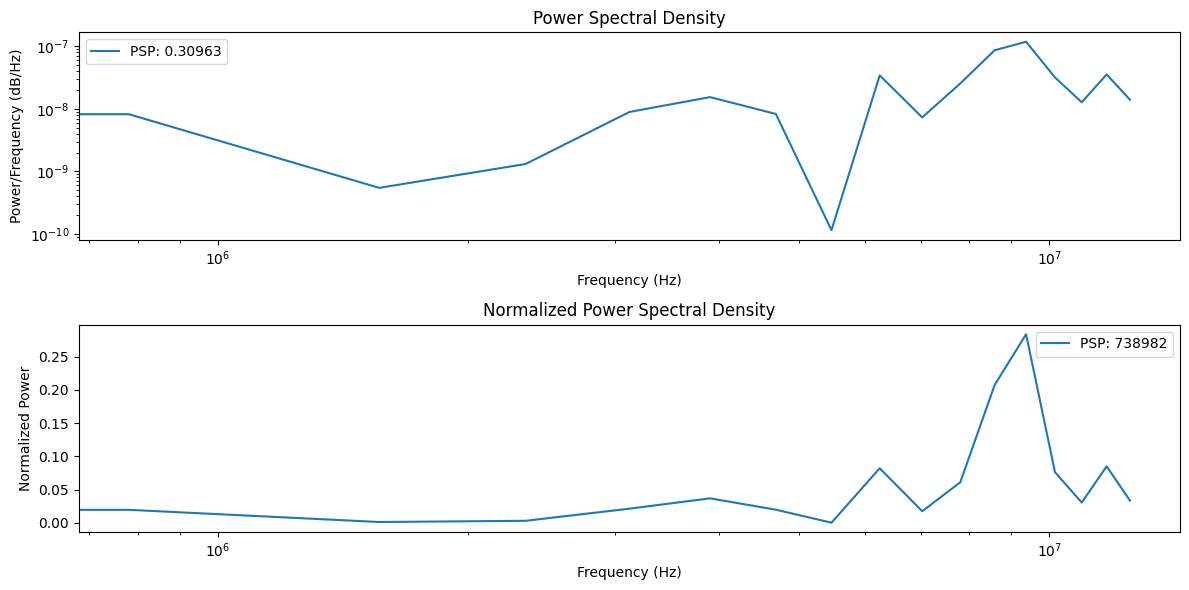

/home/carlos/.local/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 65 is greater than input length  = 53, using nperseg = 53
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/carlos/.local/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 65 is greater than input length  = 32, using nperseg = 32
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


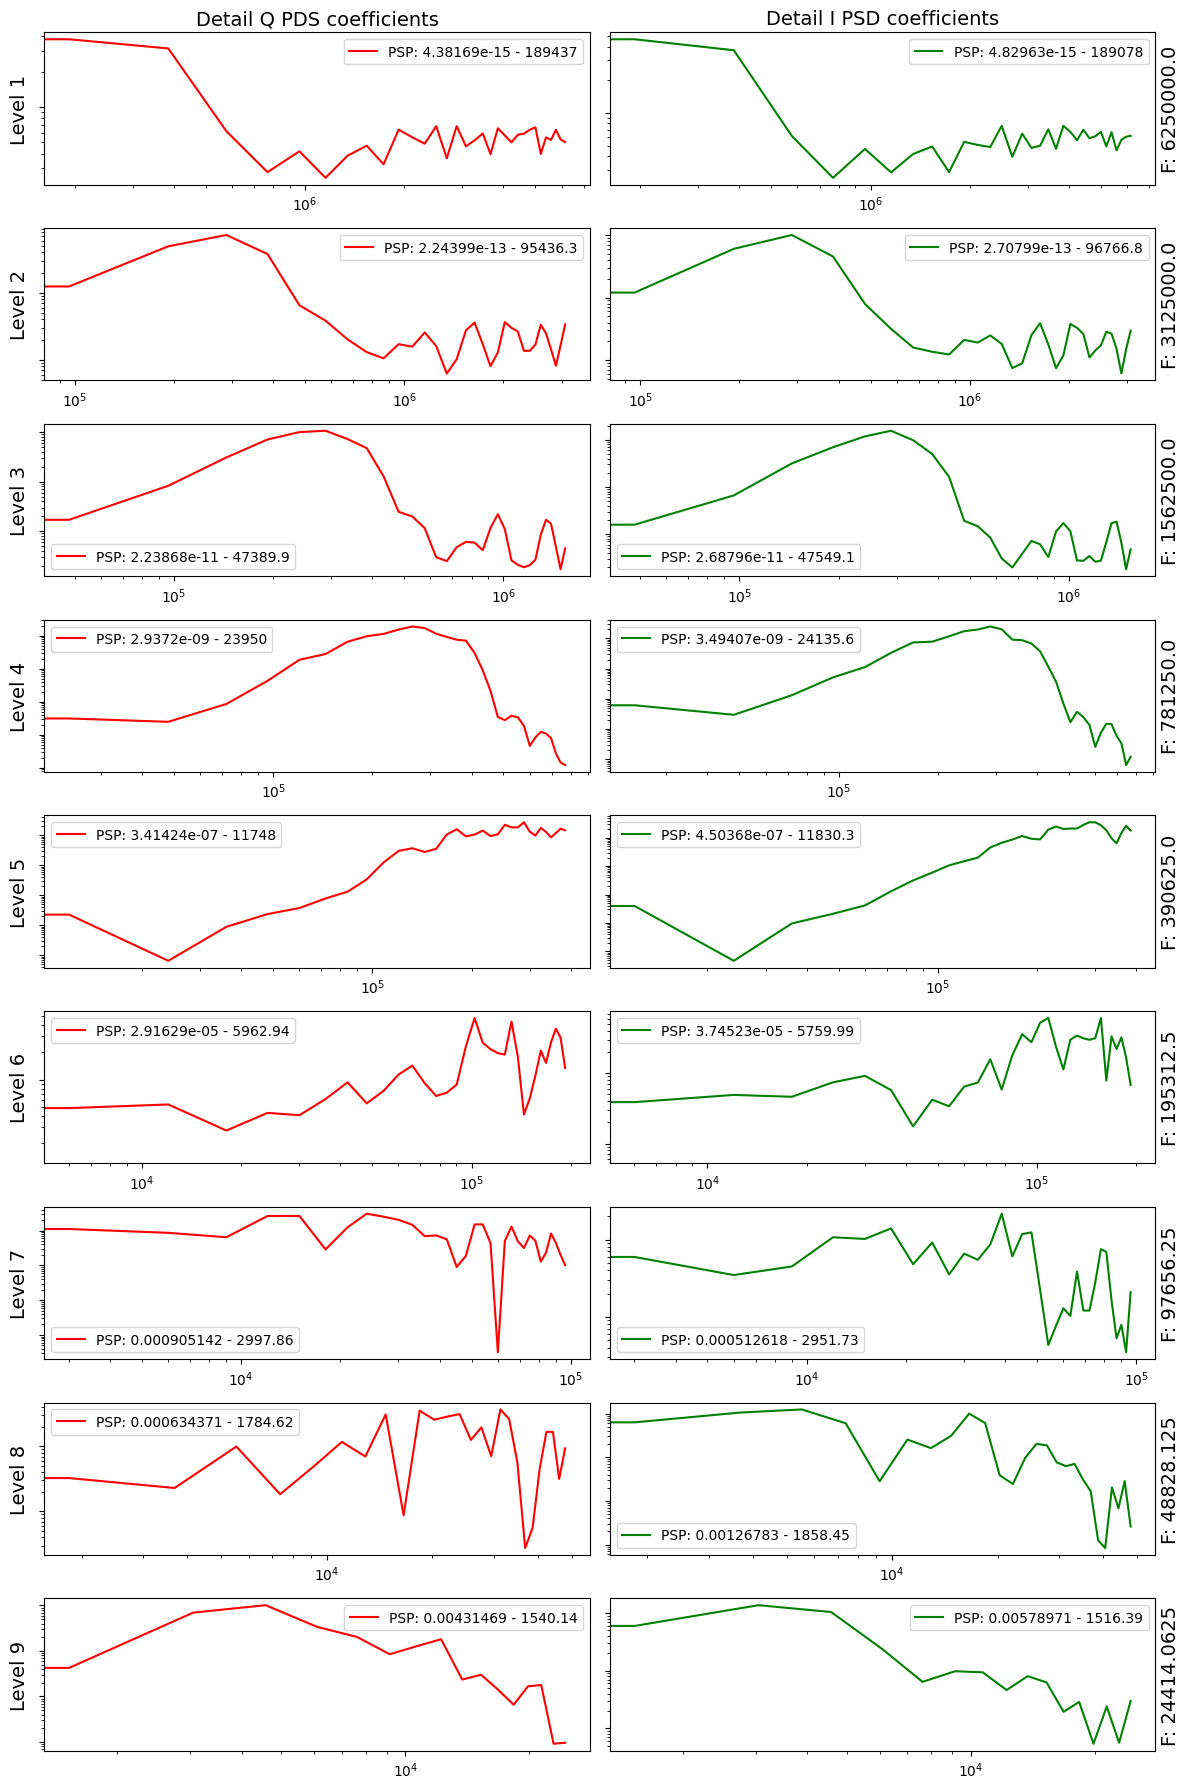

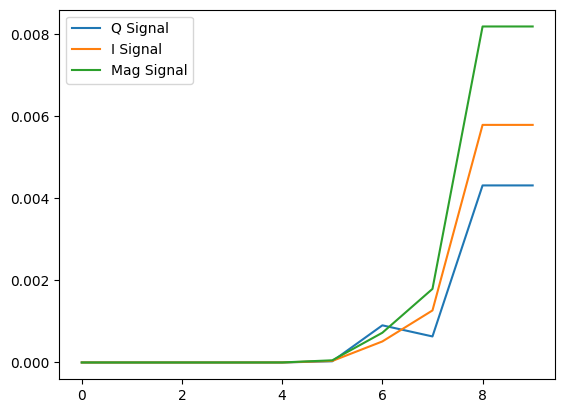

In [19]:
i_data = i_signal
q_data = q_signal
fs = 25e6
split = 9

# Compute the Power Spectral Density using Welch's method
frequencies, psd = sgn.welch(data, fs, nperseg=1024)

# Normalize the PSD
normalized_psd = psd / np.sum(psd)

#Power of Stochastic Process
psp = simpson(psd, x=frequencies)
normalized_psp = simpson(normalized_psd, x=frequencies)



# Plot the PSD
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.semilogy(frequencies, psd, label=f'PSP: {psp:0.6g}')
plt.semilogx()   
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend() 

plt.subplot(2, 1, 2)
plt.plot(frequencies, normalized_psd, label=f'PSP: {normalized_psp:0.6g}')
plt.semilogx()
plt.title('Normalized Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Power')
plt.legend()

plt.tight_layout()
plt.show()

vector_psp_i = []
vector_psp_q = []


fig, axarr = plt.subplots(nrows=split, ncols=2, figsize=(12,split*2))
for ii in range(split):

    f_s=fs/(2**(ii+1))


    (i_data, i_coeff_d) = pywt.dwt(i_data, waveletname)
    (q_data, q_coeff_d) = pywt.dwt(q_data, waveletname)
 
    i_psp_d, i_n_psp_d, i_frequencies_d, i_psd_d, i_normalized_psd_d = power_spectral_density(i_coeff_d,f_s)
    q_psp_d, q_n_psp_d, q_frequencies_d, q_psd_d, q_normalized_psd_d = power_spectral_density(q_coeff_d,f_s)

    vector_psp_q.append(q_psp_d)
    vector_psp_i.append(i_psp_d) 

    axarr[ii, 0].semilogy(q_frequencies_d, q_psd_d, 'r', label=f'PSP: {q_psp_d:0.6g} - {q_n_psp_d:0.6g}')                                                 #Approximation coefficients  0
    axarr[ii, 1].semilogy(i_frequencies_d, i_psd_d, 'g', label=f'PSP: {i_psp_d:0.6g} - {i_n_psp_d:0.6g}')                                              #Detail coefficients         1
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90) #Print on the plot the level
    axarr[ii, 1].set_ylabel("F: {}".format(fs/2**(ii+1+1)), fontsize=14, rotation=90)
    axarr[ii, 1].yaxis.set_label_position("right")
    axarr[ii, 0].set_yticklabels([])                                             #Shows the levels   
    axarr[ii, 0].legend()  # Add a legend to the plot
    axarr[ii, 1].legend()  # Add a legend to the plot
    axarr[ii, 1].semilogx()
    axarr[ii, 0].semilogx()
    if ii == 0:
        axarr[ii, 0].set_title("Detail Q PDS coefficients", fontsize=14)        #Approximation coefficients  0
        axarr[ii, 1].set_title("Detail I PSD coefficients", fontsize=14)               #Detail coefficients         1
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

vector_psp_i.append(i_psp_d)
vector_psp_q.append(q_psp_d) 


plt.plot(vector_psp_q, label="Q Signal")
plt.plot(vector_psp_i, label="I Signal")
plt.plot(np.sqrt(np.power(vector_psp_i,2) + np.power(vector_psp_i,2)), label="Mag Signal")
plt.legend() 
plt.show()

Comportamiento de las frecuencias en cada Nivel de descomposicion

/home/carlos/.local/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


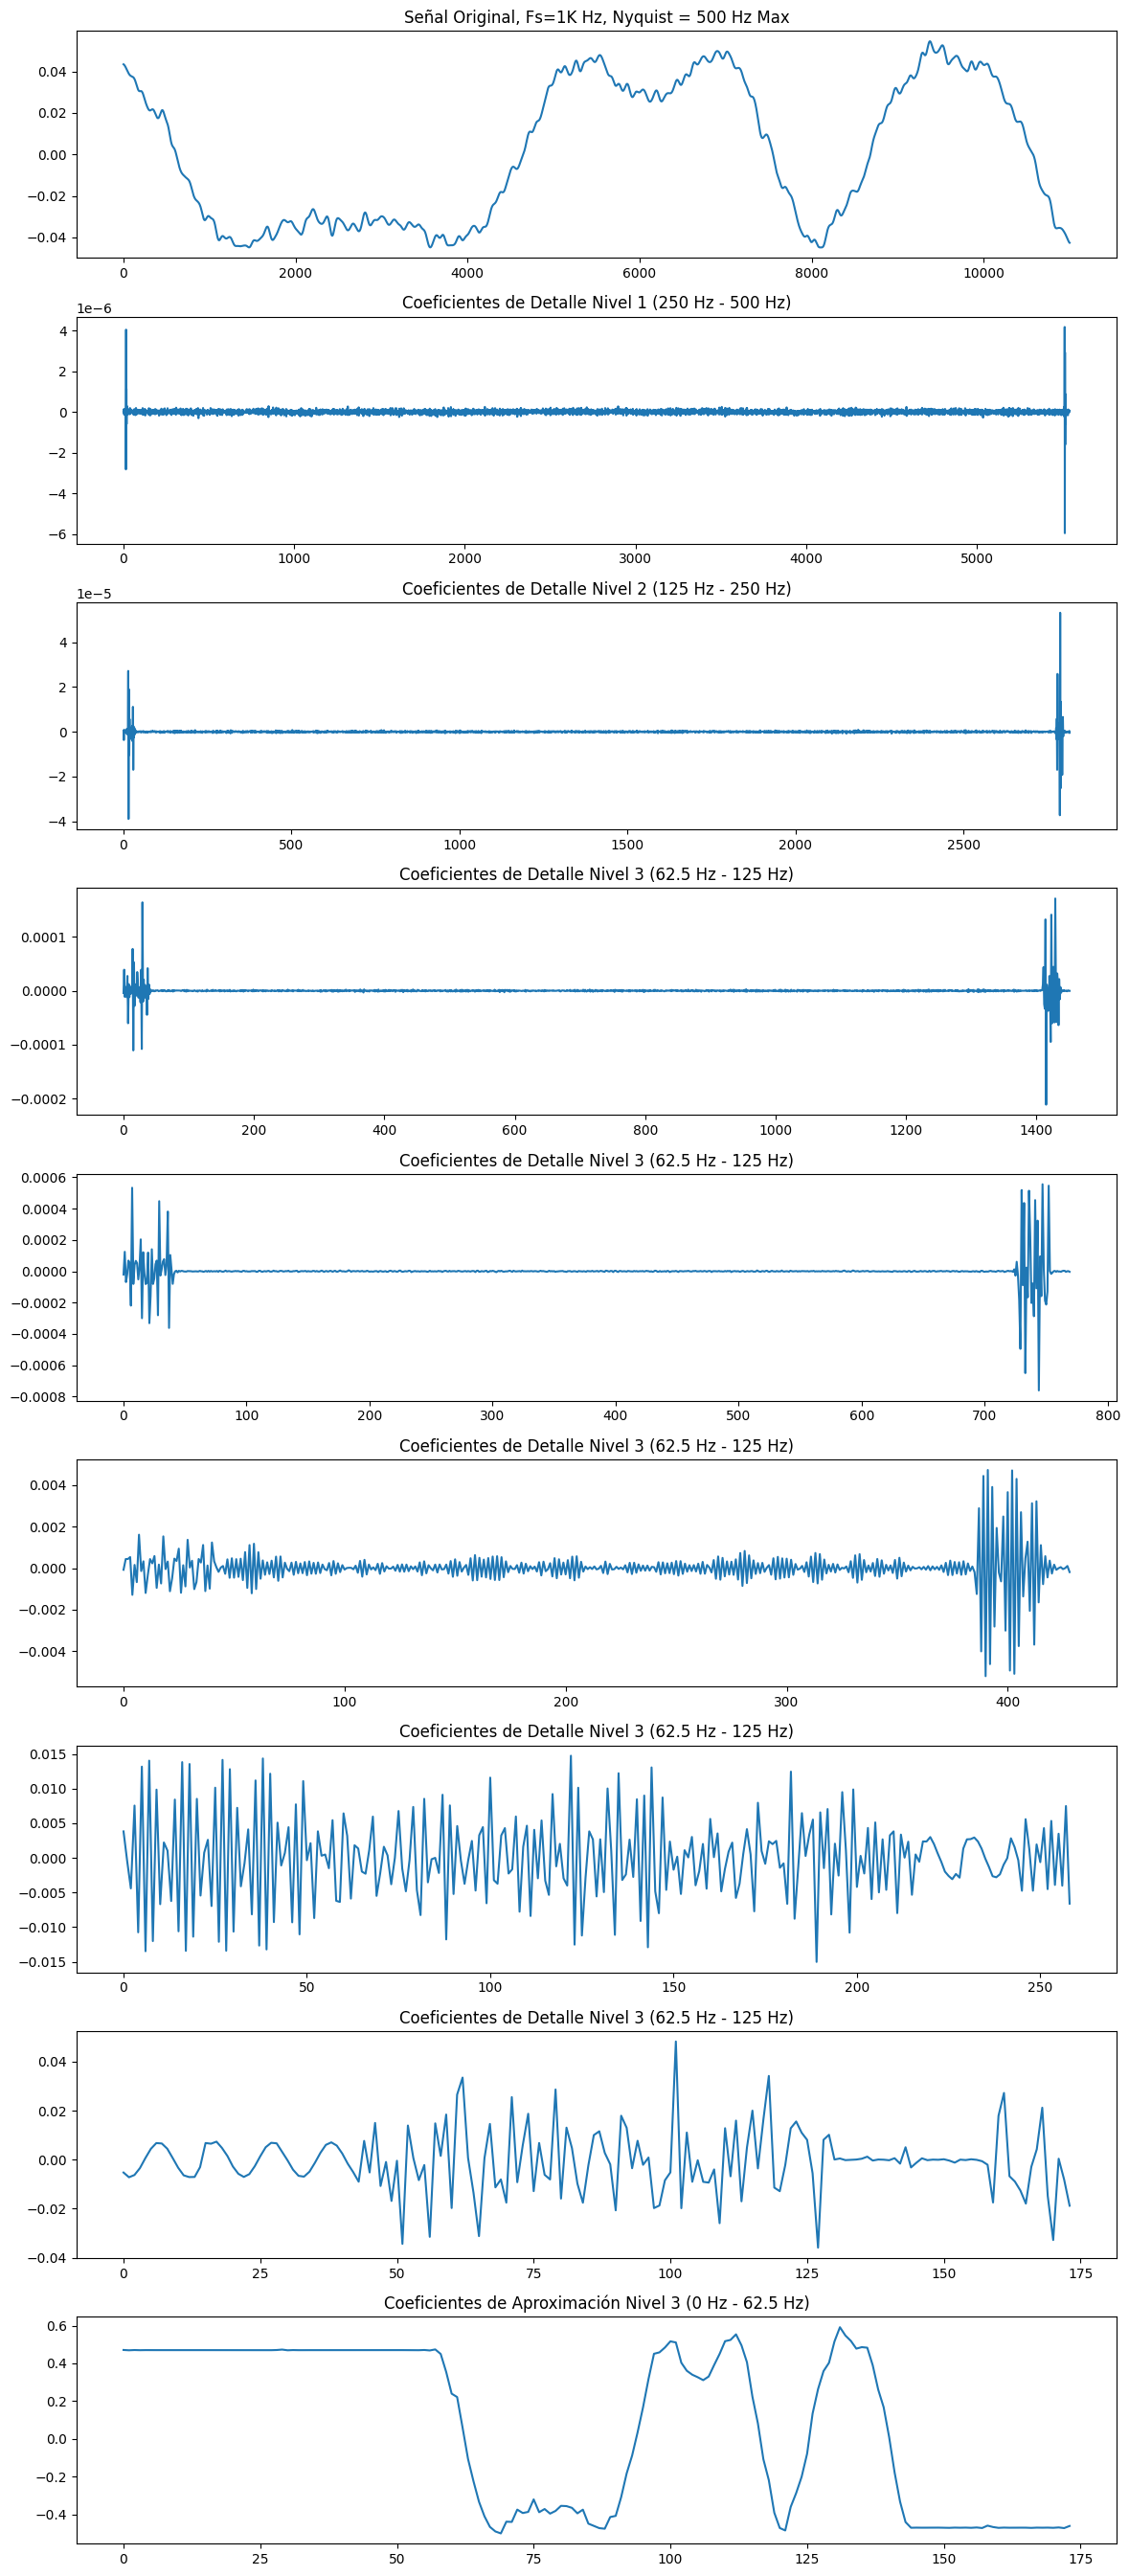

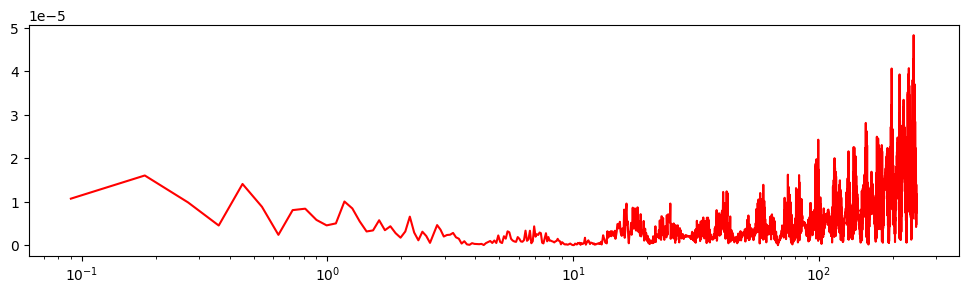

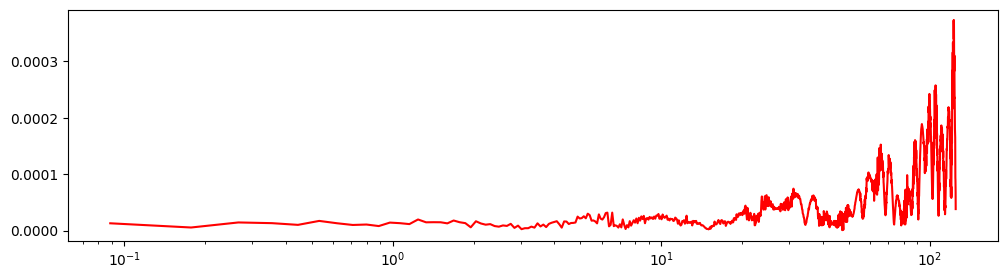

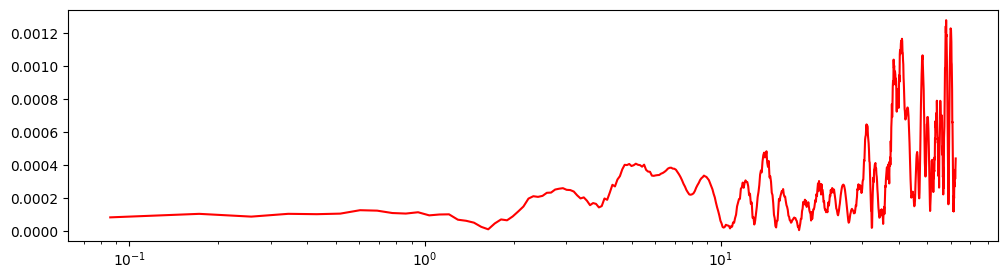

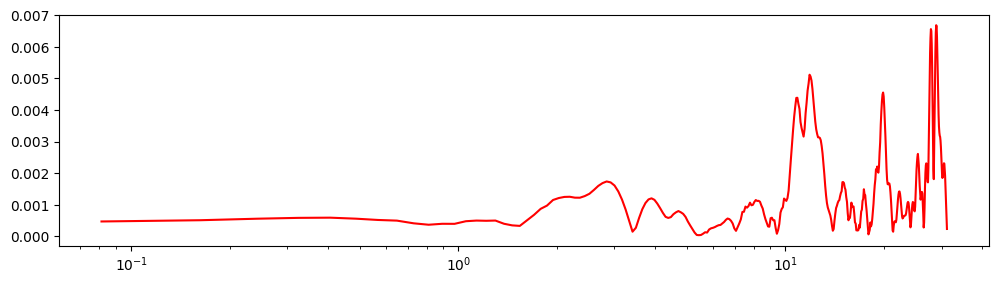

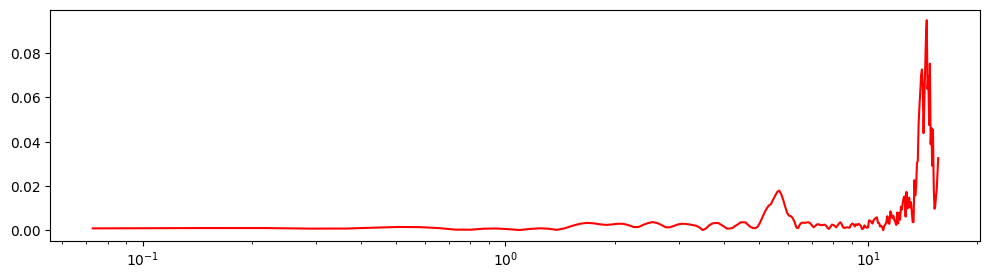

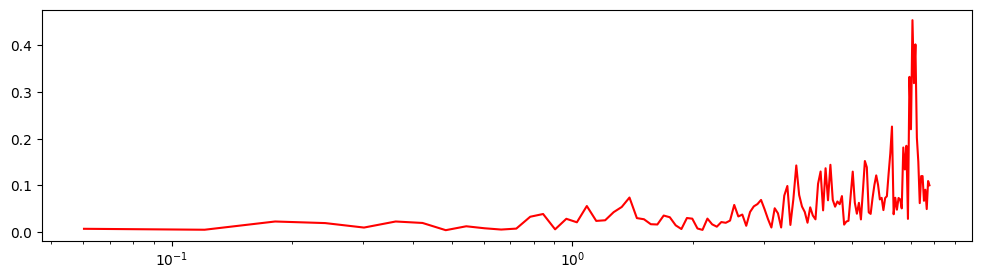

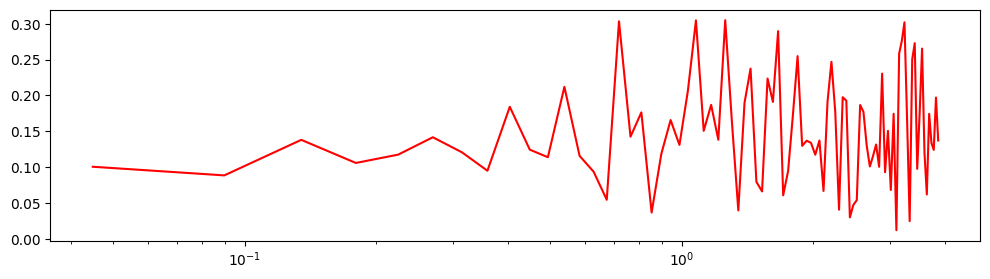

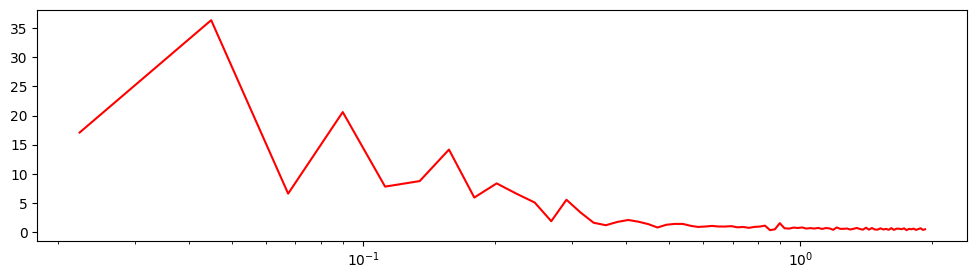

In [20]:
# Crear una señal de ejemplo (senoidal con ruido)
fs = 1000  # Hz
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 100 * t) + 0 * np.sin(2 * np.pi * 400 * t)
signal = i_signal
# Realizar la Transformada Wavelet Discreta con 3 niveles de descomposición
coeffs = pywt.wavedec(signal, 'coif15', level=7)

# Extraer los coeficientes
cA7, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

# Graficar la señal original y los coeficientes de detalle
plt.figure(figsize=(12, 3*9))

plt.subplot(9, 1, 1)
plt.plot(signal)
plt.title('Señal Original, Fs=1K Hz, Nyquist = 500 Hz Max')

plt.subplot(9, 1, 2)
plt.plot(cD1)
plt.title('Coeficientes de Detalle Nivel 1 (250 Hz - 500 Hz)')

plt.subplot(9, 1, 3)
plt.plot(cD2)
plt.title('Coeficientes de Detalle Nivel 2 (125 Hz - 250 Hz)')

plt.subplot(9, 1, 4)
plt.plot(cD3)
plt.title('Coeficientes de Detalle Nivel 3 (62.5 Hz - 125 Hz)')

plt.subplot(9, 1, 5)
plt.plot(cD4)
plt.title('Coeficientes de Detalle Nivel 3 (62.5 Hz - 125 Hz)')

plt.subplot(9, 1, 6)
plt.plot(cD5)
plt.title('Coeficientes de Detalle Nivel 3 (62.5 Hz - 125 Hz)')

plt.subplot(9, 1, 7)
plt.plot(cD6)
plt.title('Coeficientes de Detalle Nivel 3 (62.5 Hz - 125 Hz)')

plt.subplot(9, 1, 8)
plt.plot(cD7)
plt.title('Coeficientes de Detalle Nivel 3 (62.5 Hz - 125 Hz)')

plt.subplot(9, 1, 9)
plt.plot(cA7)
plt.title('Coeficientes de Aproximación Nivel 3 (0 Hz - 62.5 Hz)')

plt.tight_layout()
plt.show()


#fs= 25e6
fft_freqs_D1, fft_values_D1, power_spectrum_D1, magnitud_D1 = get_fft_values(cD1,f_s=fs/2, pos = True)
fft_freqs_D2, fft_values_D2, power_spectrum_D2, magnitud_D2 = get_fft_values(cD2,f_s=fs/4, pos = True)
fft_freqs_D3, fft_values_D3, power_spectrum_D3, magnitud_D3 = get_fft_values(cD3,f_s=fs/8, pos = True)
fft_freqs_D4, fft_values_D4, power_spectrum_D4, magnitud_D4 = get_fft_values(cD4,f_s=fs/16, pos = True)
fft_freqs_D5, fft_values_D5, power_spectrum_D5, magnitud_D5 = get_fft_values(cD5,f_s=fs/32, pos = True)
fft_freqs_D6, fft_values_D6, power_spectrum_D6, magnitud_D6 = get_fft_values(cD6,f_s=fs/64, pos = True)
fft_freqs_D7, fft_values_D7, power_spectrum_D7, magnitud_D7 = get_fft_values(cD7,f_s=fs/128, pos = True)
fft_freqs_D8, fft_values_D8, power_spectrum_D8, magnitud_D8 = get_fft_values(cA7,f_s=fs/256, pos = True)

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs_D1, magnitud_D1, 'r-')
ax.semilogx() 
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs_D2, magnitud_D2, 'r-')
ax.semilogx()
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs_D3, magnitud_D3, 'r-')
ax.semilogx()
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs_D4, magnitud_D4, 'r-')
ax.semilogx()
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs_D5, magnitud_D5, 'r-')
ax.semilogx()
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs_D6, magnitud_D6, 'r-')
ax.semilogx()
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs_D7, magnitud_D7, 'r-')
ax.semilogx()
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs_D8, magnitud_D8, 'r-')
ax.semilogx()
plt.show()


# 3.1 Analizing Signals with fourier transform

[ 0.02990616+0.02757544j  0.02978415+0.02753333j  0.02965467+0.02748866j
 ... -0.0318139 -0.0272183j  -0.03184092-0.02729856j
 -0.03187109-0.02737994j]


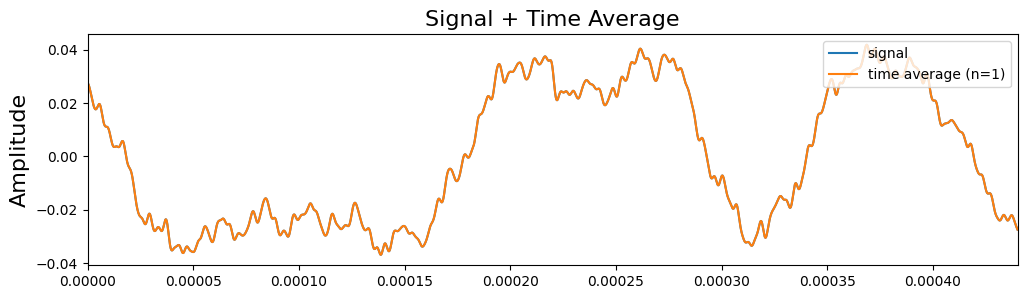

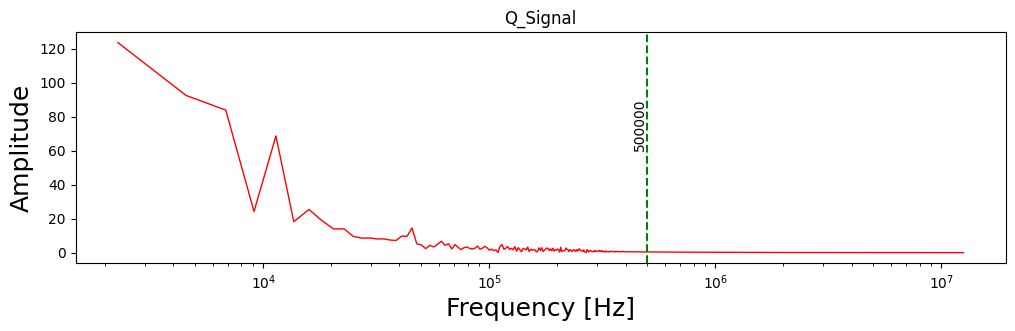

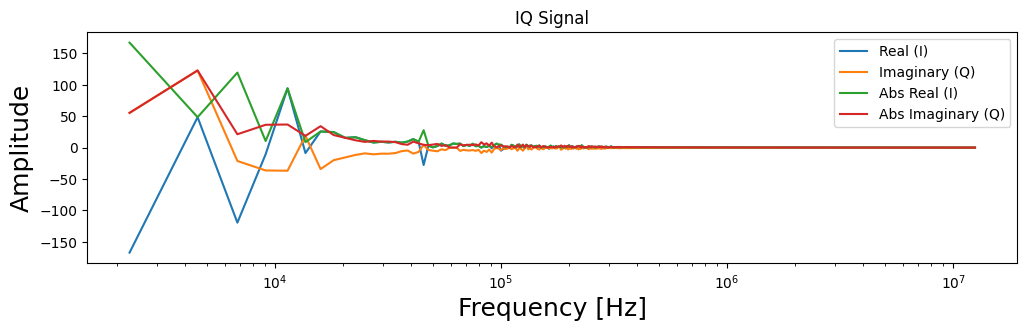

In [21]:
data_base = "../../data/"

data_dir = data_base
suffixes = [f"{i:03d}" for i in range(170)]


sufix = 1
sample = 2  #0 - 9999
sample_frequency = 25e6 

samples = load_samples(data_dir,f"{sufix:03d}")

i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]

iq_signal = np.array(i_signal + 1J*q_signal, dtype=complex)
print(iq_signal)

#iq_signal = pd.read_csv('senial.csv')

#q_signal = iq_signal.q.to_numpy()
#i_signal = iq_signal.i.to_numpy()

mag = np.sqrt(q_signal**2 + i_signal**2)
phase = np.arctan2 (q_signal,i_signal)


signal = q_signal

fs = 25e6
N = signal.shape[0]
time = np.arange(0, N) * 1/fs


fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 1)
plt.show()


fft_freqs, fft_values, power_spectrum, magnitude = get_fft_values(signal, f_s=fs, pos = True)

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
ax.plot(fft_freqs, magnitude, 'r', linewidth=1, label='FFT Power Spectrum')
ax.axvline(500000, color='g', linestyle='--')
ax.text(500000, 60, f'{500000}', rotation=90, horizontalalignment='right', verticalalignment='bottom', color='k')
ax.set_title('Q_Signal')
ax.set_xscale('log') 
plt.show()


fft_freqs, fft_values, power_spectrum, magnitud = get_fft_values(iq_signal,f_s=fs, pos = True)

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freqs, fft_values.real, label='Real (I)')
ax.plot(fft_freqs, fft_values.imag, label='Imaginary (Q)')
ax.plot(fft_freqs, np.abs(fft_values.real), label='Abs Real (I)')
ax.plot(fft_freqs, np.abs(fft_values.imag), label='Abs Imaginary (Q)')
ax.legend()  # Add a legend to the plot
ax.set_xscale('log') 
ax.set_title('IQ Signal')
ax.set_xlabel('Frequency [Hz]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plt.show()






# 3.1.a Analizing N amount of signals with fourier transform

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data directory
data_dir = "../../data/"

# Define the number of signals and files
n_signals = 10000   # 1 to 1000
m_files = 30 # 1 to 170

# Define the time interval and sampling frequency
dt = 1/25e6
fs = 25e6 

# Cut-off frequency
freq1 = 500000 # cut-off frequency 1

# Initialize aggregated vectors with a very low value (-10000)
aggregated_vector_q = np.ones(5499)*-10000
aggregated_vector_i = np.ones(5499)*-10000
aggregated_vector_mag = np.ones(5499)*-10000
aggregated_vector_phase = np.ones(5499)*-10000

# Iterate over each file
for sufix in range(m_files):

    # Load the samples from the file
    samples = load_samples(data_dir,f"{sufix:03d}")
    
    # Iterate over each signal
    for sample in range(n_signals):

        # Get the Q and I signals
        q_signal = samples[sample,:,1]
        i_signal = samples[sample,:,0]
        
        # Calculate the magnitude and phase of the signal
        mag = np.sqrt(q_signal**2 + i_signal**2)
        phase = np.arctan2(q_signal,i_signal)
        
        # Get the FFT values for the Q signal
        f_values_q, fft_values_q, power_spectrum_q, magnitude_q  = get_fft_values(q_signal, fs, pos=True)
        magnitude_q_db = 20 * np.log10(magnitude_q + 1e-10)  # Convert to dB
        aggregated_vector_q = np.amax(np.vstack([aggregated_vector_q, magnitude_q_db]), axis=0)
        
        # Get the FFT values for the I signal
        f_values_i, fft_values_i, power_spectrum_i, magnitude_i = get_fft_values(i_signal, fs)
        magnitude_i_db = 20 * np.log10(magnitude_i + 1e-10)  # Convert to dB
        aggregated_vector_i = np.amax(np.vstack([aggregated_vector_i, magnitude_i_db]), axis=0)

        # Get the FFT values for the magnitude of the signal
        f_values_mag, fft_values_mag, power_spectrum_mag, magnitude_mag = get_fft_values(mag, fs)
        magnitude_mag_db = 20 * np.log10(magnitude_mag + 1e-10)  # Convert to dB
        aggregated_vector_mag = np.amax(np.vstack([aggregated_vector_mag, magnitude_mag_db]), axis=0)
        
        # Get the FFT values for the phase of the signal
        f_values_phase, fft_values_phase, power_spectrum_phase, magnitude_phase = get_fft_values(phase, fs)
        magnitude_phase_db = 20 * np.log10(magnitude_phase + 1e-10)  # Convert to dB
        aggregated_vector_phase = np.amax(np.vstack([aggregated_vector_phase, magnitude_phase_db]), axis=0)
        
# Find the peaks in the aggregated vectors
peak_indices_q = find_peaks(aggregated_vector_q)
peak_indices_i = find_peaks(aggregated_vector_i)
peak_indices_mag = find_peaks(aggregated_vector_mag)
peak_indices_phase = find_peaks(aggregated_vector_phase)

# Function to plot the aggregated signal
def plot_agregated_signal(ax, x, y, freq_line=1, name='FFT'):
    ax.plot(x, y, 'r-')
    ax.axvline(freq_line, color='g', linestyle='--')
    ax.text(freq_line, 60, f'{freq_line}', rotation=90, horizontalalignment='right', verticalalignment='bottom', color='k')
    ax.semilogx() 
    ax.set_title(name)
    
# Plot the FFT of the Q signal
fig, ax = plt.subplots(figsize=(12,3))
plot_agregated_signal(ax, f_values_q, aggregated_vector_q, freq_line=500000, name='Q Signal FFT')
plt.show()

# Plot the FFT of the I signal
fig, ax = plt.subplots(figsize=(12,3))
plot_agregated_signal(ax, f_values_i, aggregated_vector_i, freq_line=500000, name='I Signal FFT')
plt.show()

# Plot the FFT of the magnitude of the signal
fig, ax = plt.subplots(figsize=(12,3))
plot_agregated_signal(ax, f_values_mag, aggregated_vector_mag, freq_line=1000000, name='Magnitude Signal FFT')
plt.show()

# Plot the FFT of the phase of the signal
fig, ax = plt.subplots(figsize=(12,3))
plot_agregated_signal(ax, f_values_phase, aggregated_vector_phase, freq_line=1000000, name='Phase Signal FFT')
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5499 and the array at index 1 has size 5500

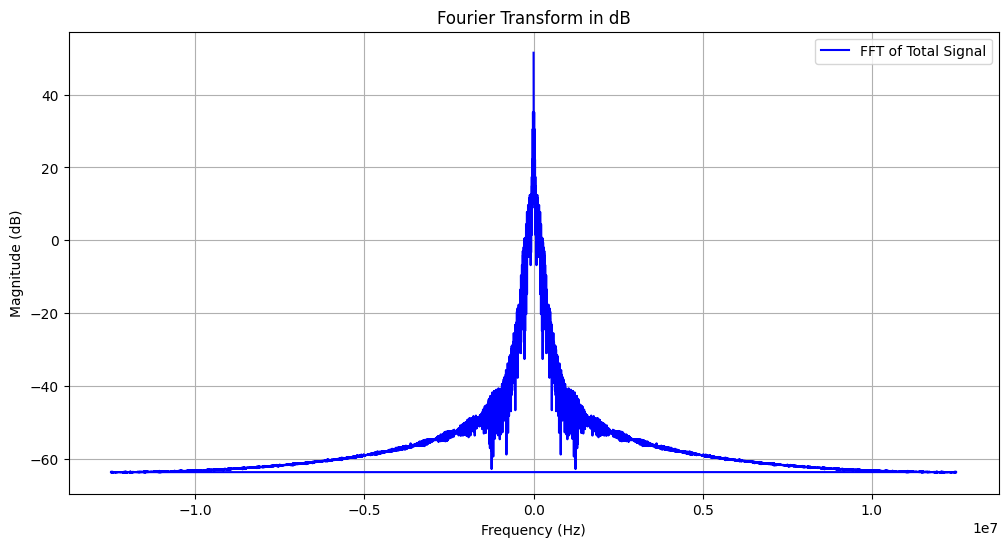

Significant frequency components (Hz): [      0.            2272.72727273    4545.45454545    6818.18181818
    9090.90909091   11363.63636364   13636.36363636   15909.09090909
   18181.81818182   20454.54545455   22727.27272727   25000.
   27272.72727273   29545.45454545   31818.18181818   34090.90909091
   36363.63636364   38636.36363636   40909.09090909   43181.81818182
   45454.54545455   47727.27272727   50000.           52272.72727273
   54545.45454545   56818.18181818   59090.90909091   61363.63636364
   63636.36363636   65909.09090909   68181.81818182   70454.54545455
   72727.27272727   75000.           77272.72727273   79545.45454545
   81818.18181818   84090.90909091   86363.63636364   88636.36363636
   90909.09090909   93181.81818182   95454.54545455   97727.27272727
  100000.          102272.72727273  104545.45454545  106818.18181818
  109090.90909091  111363.63636364  113636.36363636  115909.09090909
  118181.81818182  120454.54545455  122727.27272727  125000.
  127272.72

In [31]:
import numpy as np
import matplotlib.pyplot as plt

data_dir = "../../data/"
suffixes = [f"{i:03d}" for i in range(170)]

sufix = 1
sample = 2  # 0 - 9999
fs = 25e6  # sample_frequency

samples = load_samples(data_dir, f"{sufix:03d}")

# Obtain I[0] and Q[1] signals
i_signal = samples[sample, :, 0]
q_signal = samples[sample, :, 1]

# Calculate the magnitude and phase of the IQ signal
mag = np.sqrt(q_signal**2 + i_signal**2)
phase = np.arctan2(q_signal, i_signal)

# Parameters
N = len(i_signal)  # Number of samples
t = np.arange(0, N) * 1/fs

s = mag

# --- Fourier Transform ---
f = np.fft.fftfreq(N, d=1/fs)  # Frequency axis
#f = np.fft.fftshift(f)  # Center at f=0

# FFT of the total signal
S = np.fft.fft(s)
#S = np.fft.fftshift(S)  # Shift to center the spectrum at 0 Hz

# Convert to magnitude in dB
def to_dB(X):
    return 10 * np.log10(np.abs(X)**2 + 1e-10)  # Avoid log(0)

S_dB = to_dB(S)

# --- Plotting ---
plt.figure(figsize=(12, 6))

plt.plot(f, S_dB, label="FFT of Total Signal", color='b')

plt.title("Fourier Transform in dB")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid()
# plt.xlim(-50, 50)  # Show only relevant frequencies
plt.show()

# --- Additional Analysis ---
# Identify frequency components with significant power
threshold_dB = -20  # Example threshold in dB
significant_freqs = f[S_dB > threshold_dB]
significant_magnitudes = S_dB[S_dB > threshold_dB]

print("Significant frequency components (Hz):", significant_freqs)
print("Corresponding magnitudes (dB):", significant_magnitudes)

# Hola Mundo

El codigo que tienes que correr es
```
sudo apt install blah
```


# Visualizing the State-Space using the Continuous Wavelet Transform

Scale: 29.857055729177844, Frequency: 502393.8105638873
Scale: 29.97216122305712, Frequency: 500464.41056979
Scale: 30.087710473844005, Frequency: 498542.42026956065
Scale: 30.203705192318676, Frequency: 496627.8112069097
Scale: 30.320147095856687, Frequency: 494720.55503483297
Scale: 30.437037908454453, Frequency: 492820.6235151901
Scale: 30.554379360754826, Frequency: 490927.98851828603
Scale: 30.672173190072613, Frequency: 489042.6220224563
Scale: 30.79042114042037, Frequency: 487164.496113651
Scale: 30.909124962534182, Frequency: 485293.58298502205
Scale: 31.02828641389966, Frequency: 483429.8549365101
Scale: 31.147907258777852, Frequency: 481573.2843744364
Scale: 31.267989268231425, Frequency: 479723.84381109354
Scale: 31.38853422015093, Frequency: 477881.505864337
Scale: 31.509543899281024, Frequency: 476046.2432571823
Scale: 31.631020097246935, Frequency: 474218.0288173998
Scale: 31.752964612581074, Frequency: 472396.8354771113
Scale: 31.875379250749518, Frequency: 470582.636272

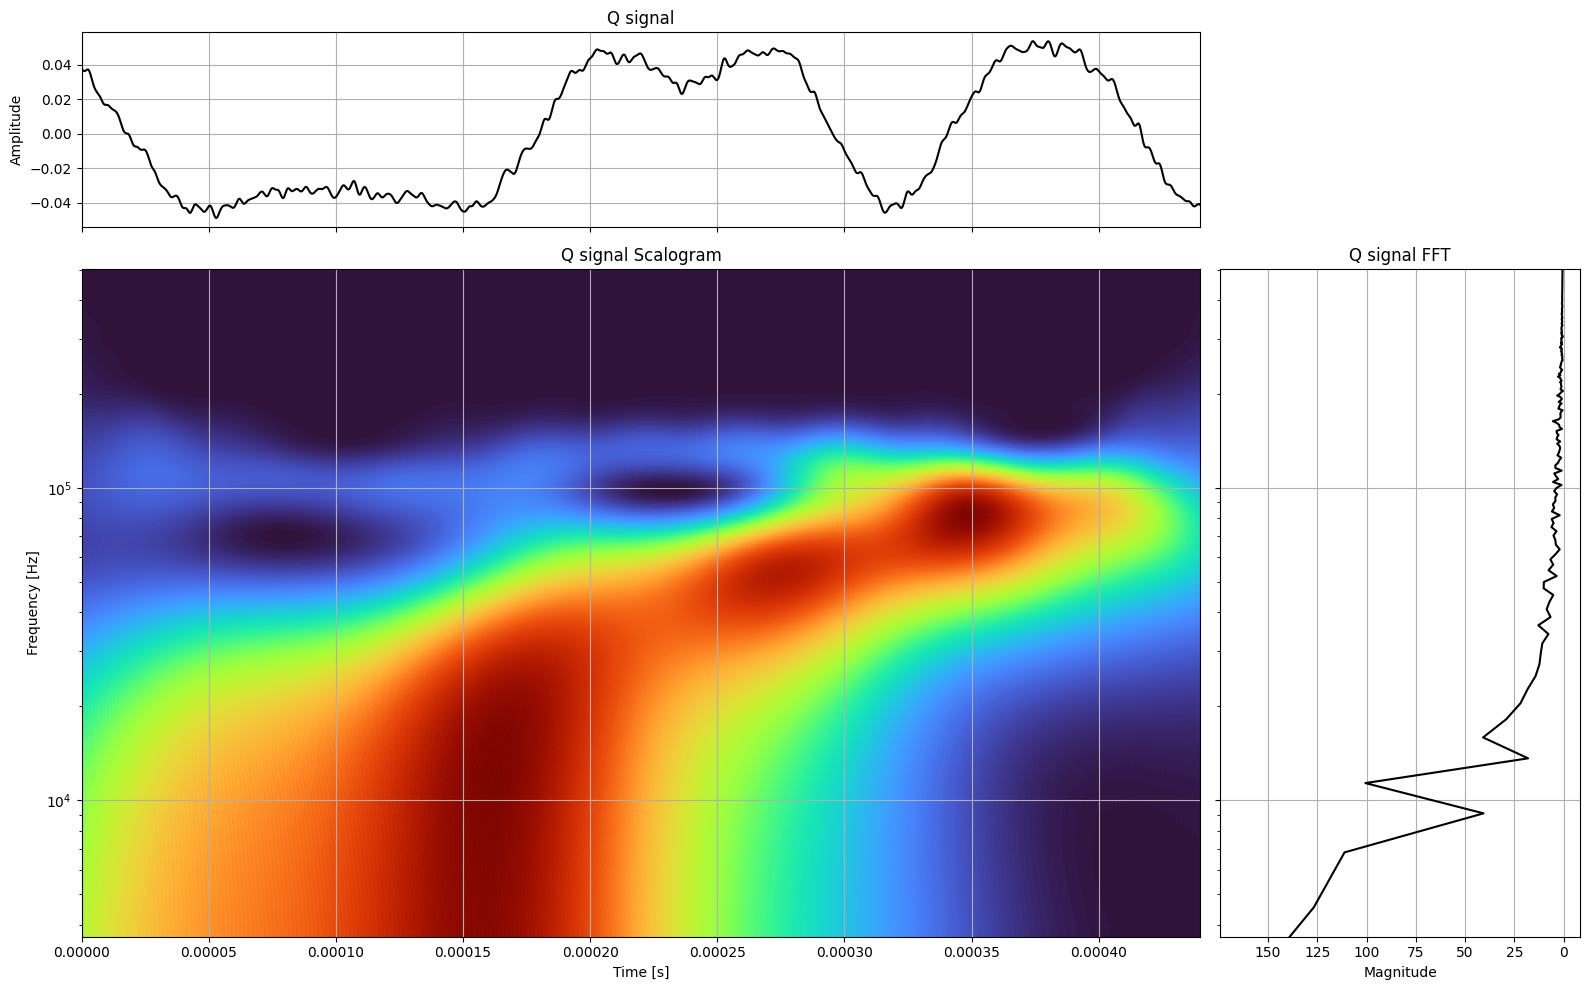

Scale: 29.857055729177844, Frequency: 502393.8105638873
Scale: 29.97216122305712, Frequency: 500464.41056979
Scale: 30.087710473844005, Frequency: 498542.42026956065
Scale: 30.203705192318676, Frequency: 496627.8112069097
Scale: 30.320147095856687, Frequency: 494720.55503483297
Scale: 30.437037908454453, Frequency: 492820.6235151901
Scale: 30.554379360754826, Frequency: 490927.98851828603
Scale: 30.672173190072613, Frequency: 489042.6220224563
Scale: 30.79042114042037, Frequency: 487164.496113651
Scale: 30.909124962534182, Frequency: 485293.58298502205
Scale: 31.02828641389966, Frequency: 483429.8549365101
Scale: 31.147907258777852, Frequency: 481573.2843744364
Scale: 31.267989268231425, Frequency: 479723.84381109354
Scale: 31.38853422015093, Frequency: 477881.505864337
Scale: 31.509543899281024, Frequency: 476046.2432571823
Scale: 31.631020097246935, Frequency: 474218.0288173998
Scale: 31.752964612581074, Frequency: 472396.8354771113
Scale: 31.875379250749518, Frequency: 470582.636272

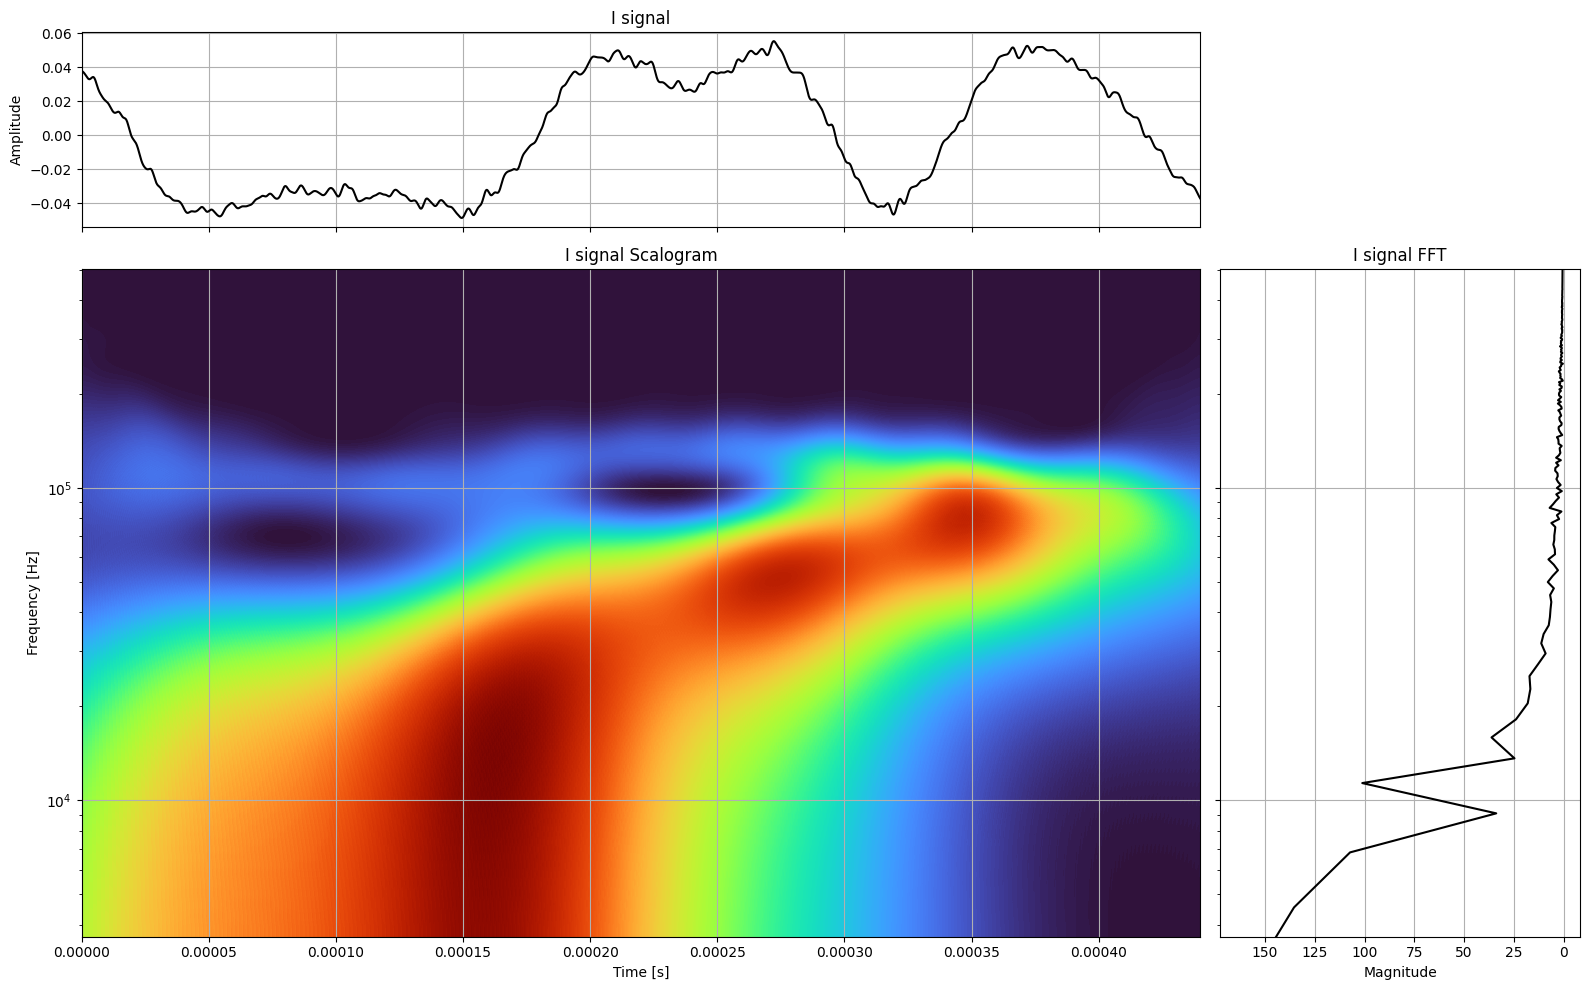

Scale: 29.857055729177844, Frequency: 502393.8105638873
Scale: 29.97216122305712, Frequency: 500464.41056979
Scale: 30.087710473844005, Frequency: 498542.42026956065
Scale: 30.203705192318676, Frequency: 496627.8112069097
Scale: 30.320147095856687, Frequency: 494720.55503483297
Scale: 30.437037908454453, Frequency: 492820.6235151901
Scale: 30.554379360754826, Frequency: 490927.98851828603
Scale: 30.672173190072613, Frequency: 489042.6220224563
Scale: 30.79042114042037, Frequency: 487164.496113651
Scale: 30.909124962534182, Frequency: 485293.58298502205
Scale: 31.02828641389966, Frequency: 483429.8549365101
Scale: 31.147907258777852, Frequency: 481573.2843744364
Scale: 31.267989268231425, Frequency: 479723.84381109354
Scale: 31.38853422015093, Frequency: 477881.505864337
Scale: 31.509543899281024, Frequency: 476046.2432571823
Scale: 31.631020097246935, Frequency: 474218.0288173998
Scale: 31.752964612581074, Frequency: 472396.8354771113
Scale: 31.875379250749518, Frequency: 470582.636272

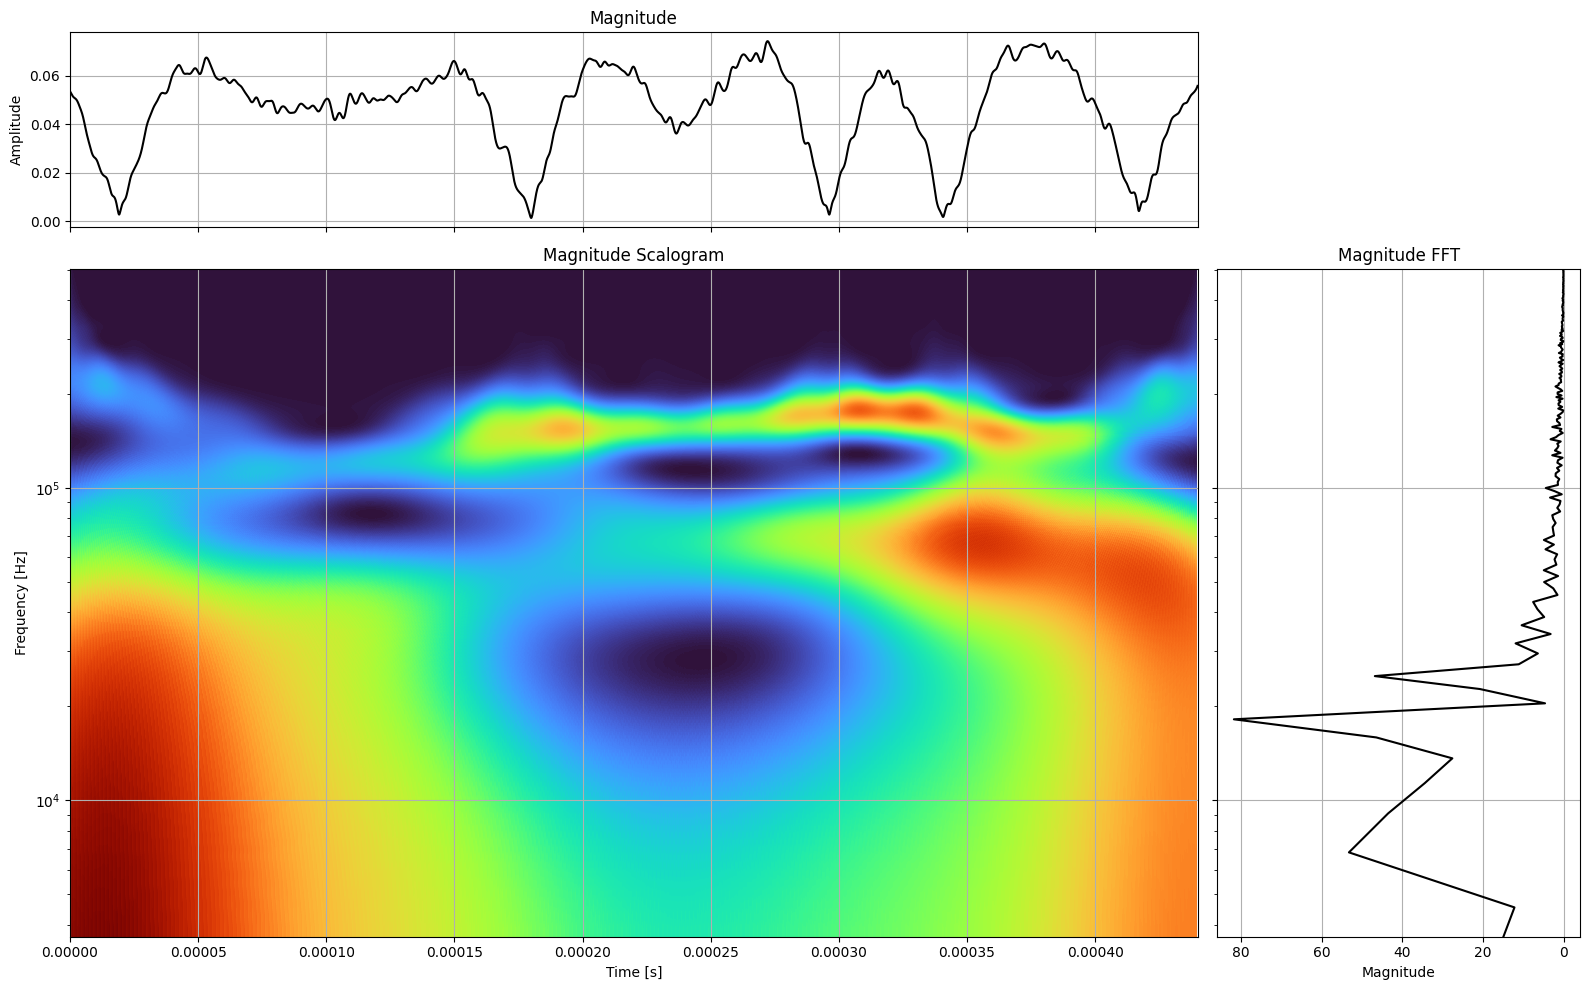

Scale: 29.857055729177844, Frequency: 502393.8105638873
Scale: 29.97216122305712, Frequency: 500464.41056979
Scale: 30.087710473844005, Frequency: 498542.42026956065
Scale: 30.203705192318676, Frequency: 496627.8112069097
Scale: 30.320147095856687, Frequency: 494720.55503483297
Scale: 30.437037908454453, Frequency: 492820.6235151901
Scale: 30.554379360754826, Frequency: 490927.98851828603
Scale: 30.672173190072613, Frequency: 489042.6220224563
Scale: 30.79042114042037, Frequency: 487164.496113651
Scale: 30.909124962534182, Frequency: 485293.58298502205
Scale: 31.02828641389966, Frequency: 483429.8549365101
Scale: 31.147907258777852, Frequency: 481573.2843744364
Scale: 31.267989268231425, Frequency: 479723.84381109354
Scale: 31.38853422015093, Frequency: 477881.505864337
Scale: 31.509543899281024, Frequency: 476046.2432571823
Scale: 31.631020097246935, Frequency: 474218.0288173998
Scale: 31.752964612581074, Frequency: 472396.8354771113
Scale: 31.875379250749518, Frequency: 470582.636272

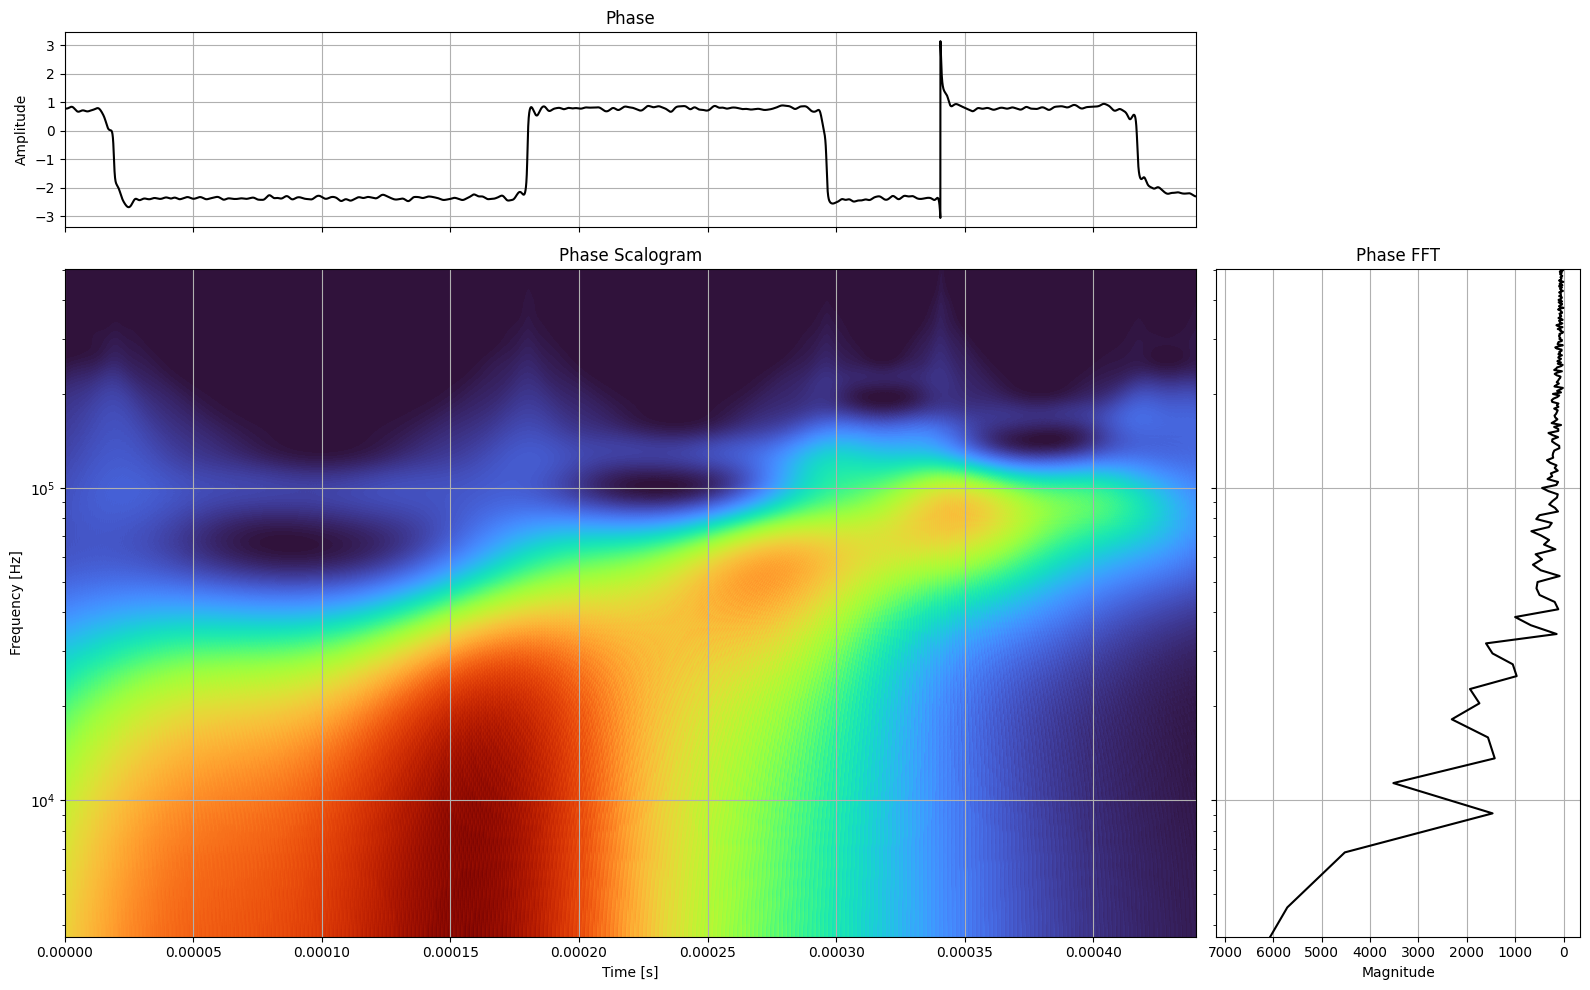

In [ ]:
data_dir = "../../data/"
suffixes = [f"{i:03d}" for i in range(170)]

sufix = 1
sample = 20  #0 - 9999
sample_frequency = 25e6 

samples = load_samples(data_dir,f"{sufix:03d}")

i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]
iq_signal = np.array(i_signal + 1J*q_signal, dtype=complex)

mag = np.sqrt (q_signal**2 + i_signal**2)
phase = np.arctan2 (q_signal,i_signal)

def calculate_scalogram_with_time_series_and_fft(vector, wavelet='cmor', scales=None, sampling_rate=1, plot_name = ''):
    """
    Calculate and plot the scalogram of the wavelet transform of a given vector.
    Also, plot the time series at the top and the FFT on the right.
    
    Parameters:
    vector (array-like): The input signal vector.
    wavelet (str): The wavelet to use. Default is 'cmor'.
    scales (array-like): The scales to use for the wavelet transform. Default is None, which uses a range of scales.
    sampling_rate (float): The sampling rate of the signal. Default is 1.
    """
    if scales is None:
        scales = np.arange(1, 128)
        print(scales)
    
    # Compute the Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(vector, scales, wavelet, sampling_period=1/sampling_rate)

    # Convert scales to frequencies
    scale_freq = pywt.scale2frequency(wavelet, scales)*sampling_rate
    
    # Print scales and corresponding frequencies
    for scale, freq in zip(scales, scale_freq):
        print(f"Scale: {scale}, Frequency: {freq}")
    
    # Compute power of the signals
    power = np.abs(coefficients) ** 2
    
    # Compute FFT
    fft_vals = np.fft.fft(vector)
    fft_freqs = np.fft.fftfreq(len(vector), d=1/sampling_rate)
    
    # Filter to keep only positive frequencies
    positive_freqs = fft_freqs > 0
    fft_vals = fft_vals[positive_freqs]
    fft_freqs = fft_freqs[positive_freqs]
    
    # Create the figure with subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(4, 4)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1:, :-1], sharex=ax1)
    ax3 = fig.add_subplot(gs[1:, -1], sharey=ax2)
    
    # Plot the time series
    time = np.arange(len(vector)) / sampling_rate
    ax1.plot(time, vector, color='black')
    ax1.set_title(plot_name)
    ax1.set_ylabel('Amplitude')
    ax1.grid(True)
    ax1.label_outer()
    
    # Plot the scalogram
    #extent = [time[0], time[-1], frequencies[-1], frequencies[0]]
    extent = [time[0], time[-1], frequencies.min(), frequencies.max()]
    ax2.imshow(power, extent=extent, cmap = plt.cm.turbo, aspect='auto', vmax=power.max(), vmin=0)
    ax2.set_title(plot_name + ' Scalogram')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Frequency [Hz]')
    #ax2.set_yscale('log')  # Set the y-axis to log scale
    ax2.grid(True)

    ax2.set_ylim(frequencies.min(), frequencies.max())
    
    # Plot the FFT
    ax3.plot(np.abs(fft_vals), fft_freqs, color='black')
    ax3.set_title(plot_name + ' FFT')
    ax3.set_xlabel('Magnitude')
    ax3.invert_xaxis()  # To flip it 90 degrees
    ax3.grid(True)
    ax3.semilogy() 
    ax3.label_outer()
    
    plt.tight_layout()
    plt.show()

# Example usage
end_exp = 11
scale = 2**np.linspace(4.9, end_exp + 1,1280)
wave = 'cgau5'

calculate_scalogram_with_time_series_and_fft(q_signal, scales = scale,wavelet=wave, sampling_rate=25e6, plot_name= 'Q signal')
calculate_scalogram_with_time_series_and_fft(i_signal, scales = scale,wavelet=wave, sampling_rate=25e6, plot_name= 'I signal')
calculate_scalogram_with_time_series_and_fft(mag, scales = scale, wavelet=wave, sampling_rate=25e6, plot_name= 'Magnitude')
calculate_scalogram_with_time_series_and_fft(phase, scales = scale, wavelet=wave, sampling_rate=25e6, plot_name= 'Phase')


# Calculate of Characteristics Using Discrete Wavelet Transform

Note: For run the code you have to run each part of the code separately from HERE

Loading the data set and convert it in a dictionary

If you want to see the histogram of the satelites activate the funcion plot_hist

If you want to see the whole graphics od the signals activate the funcrion print_all_signals

In [10]:
data_dir = "../../data/"
suffixes = [f"{i:03d}" for i in range(170)]

sufix = 3
sample = 2  #0 - 9999
sample_frequency = 25e6 

samples = load_samples(data_dir,f"{sufix:03d}")
id, cells = load_data(data_dir,f"{sufix:03d}")
id_tx = get_id_cell


#print(id.shape)

i_signals = samples[:,:,0]
q_signals = samples[:,:,1]

i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]

def build_dict_signal (signal, id):
    dict_sinal= defaultdict(list)
    for ii, label in enumerate(id):
        dict_sinal[label].append(signal[ii])
    print('dictionary created')
    return dict_sinal

dict_sinal_i = build_dict_signal(i_signals, id)
dict_sinal_q = build_dict_signal(q_signals, id)
dict_sinal_iq =build_dict_signal(samples, id)

def print_all_signals(dict_signal):
    for ii in sorted(list(dict_signal.keys())):
        fig, ax = plt.subplots(figsize=(12,3))
        signals = dict_signal.get(ii)
        for i in range(len(signals)):
            ax.plot(signals[i])
            ax.set_title(f'{ii} and Total of Signals {len(signals)}')
        plt.show()

#plot_hist(id, bins = 128, title = 'Histogram', col_labels = True, procent= False)
#plot_hist(cells, bins = 64, title = 'Histogram', col_labels = True, procent= False)
print(dict_sinal_iq.keys())
#print_all_signals(dict_sinal_i)

"""
# Example how to acces to the IQ dictonary 

# Assuming dict_sinal_iq is a dictionary where each key maps to a list of IQ numpy arrays.

# Print all the keys in the dictionary dict_sinal_iq.
print(dict_sinal_iq.keys())

# Get the value associated with the key 17 from the dictionary. This value is expected to be a list of numpy arrays.
value = dict_sinal_iq.get(17)

# Print the first column of the 31st numpy array (index 30) in the list associated with the key 17.
print(value[30][:, 0])

# Print the second column of the 31st numpy array (index 30) in the list associated with the key 17.
print(value[30][:, 1])

# Plot the first column of the 3rd numpy array (index 2) in the list associated with the key 17.
plt.plot(value[2][:, 0])

# Plot the second column of the 3rd numpy array (index 2) in the list associated with the key 17.
plt.plot(value[2][:, 1])

# Display the plot with the two lines created above.
plt.show()

"""



dictionary created
dictionary created
dictionary created
dict_keys([50, 78, 48, 104, 115, 71, 55, 28, 88, 87, 85, 67, 31, 79, 81, 73, 1, 42, 92, 89, 33, 69, 72, 99, 2, 65, 123, 57, 45, 29, 36, 110, 68, 0, 44, 43, 34, 11, 25, 127, 46, 16, 18, 112, 90, 30, 113, 17, 49, 76, 3, 26, 32, 23, 103, 40, 96, 4, 94, 114, 13, 22, 6, 63, 8, 7, 9, 41, 60, 24, 38, 10, 97, 101])


'\n# Example how to acces to the IQ dictonary \n\n# Assuming dict_sinal_iq is a dictionary where each key maps to a list of IQ numpy arrays.\n\n# Print all the keys in the dictionary dict_sinal_iq.\nprint(dict_sinal_iq.keys())\n\n# Get the value associated with the key 17 from the dictionary. This value is expected to be a list of numpy arrays.\nvalue = dict_sinal_iq.get(17)\n\n# Print the first column of the 31st numpy array (index 30) in the list associated with the key 17.\nprint(value[30][:, 0])\n\n# Print the second column of the 31st numpy array (index 30) in the list associated with the key 17.\nprint(value[30][:, 1])\n\n# Plot the first column of the 3rd numpy array (index 2) in the list associated with the key 17.\nplt.plot(value[2][:, 0])\n\n# Plot the second column of the 3rd numpy array (index 2) in the list associated with the key 17.\nplt.plot(value[2][:, 1])\n\n# Display the plot with the two lines created above.\nplt.show()\n\n'

Calculating the fratures per Transmition Satellite Signal 

In [6]:

wavelet = 'coif7'
#kind_features = ['psp', 'entropy', 'crossings', 'statistics']
#kind_features = ['psp', 'entropy', 'statistics']
#kind_features = ['psp', 'entropy']
kind_features = ['psp']
#kind_features = ['entropy']

def list_features(dict_signal, wavelet, level = 9, fs=25e6, kind_features=['psp'], flip ='True'):
    """
    Extract features from the signal dictionary using wavelet decomposition.

    Parameters:
    dict_signal (dict): Dictionary where keys are labels and values are lists of signals (numpy arrays).
    wavelet (str): The type of wavelet to use for decomposition.
    level (int): The level of decomposition. Default is 9.
    fs (float): Sampling frequency. Default is 25e6.
    flip(Bool): Flip the list of DWT decomposition coefficients to reverse the order cD1, cD2, ..., cDn, cAn

    Returns:
    tuple: A tuple containing the list of features and the corresponding labels.

    # Example usage
    features, list_labels_sat = list_features(dict_signal, wavelet='coif14', level=9)
    """
    
    i=-1
    #list_labels = []
    list_labels_sat = []
    list_features = []


    for key, value in dict_signal.items():
        # Iterate over each signal for the current key

        for signal in value:
            i+=1
            k=0
            features = []
            list_labels_sat.append(key)
            
            # Perform wavelet decomposition
            list_coeff = pywt.wavedec(signal, wavelet, level=level)       
            # Generate the frequency scale
            f_s = [fs/2**(level+1)] + [fs/2**(i+1) for i in range(level, 0, -1)]
           
            if flip == 'True':
                # Flip the list of decomposition coefficients to reverse the order
                list_coeff = list_coeff[::-1]
                # Flip the frequency scale list to reverse the order
                f_s = f_s[::-1]
            else:
                None


            # Iterate through each level of decomposition coefficients
            #Here it take each Detail Coeffitient cAn, cDn ... cD2, cD1, Note that it depends of the number of levels of the signal decomposition  for N levels there are N+1 vectors of coeffitients
            for coeff in list_coeff: 
                
                features += get_features(coeff, fs=f_s[k], include_features=kind_features) #Compute the characteristics of each level and concatenate with the whole levels  
                #print(f'Sattellite :{key} , Signal: {i} , coeff len: {len(coeff)}, len Features: {len(features)}, freq: {f_s[k]}')    #Activate just if you want to analize the data here
                k+=1

            # Append the features to the list                
            list_features.append(features)
            #print(f'Sattellite {key} Signal {i} characteristics len {len(features)}') 
        #print(len(list_features))
    return list_features, list_labels_sat

features_i, list_labels_sat_i = list_features(dict_sinal_i, wavelet = wavelet, level = 8, fs=25e6,kind_features=kind_features, flip ='True')
features_q, list_labels_sat_q = list_features(dict_sinal_q, wavelet = wavelet, level = 8, fs=25e6,kind_features=kind_features, flip ='True')

#Concatenate de features of I signal and Q signal
features_iq = [v1 + v2 for v1, v2 in zip(features_i, features_q)]



print(len(features_i))



10000


In [38]:
list_labels_sat = []
list_features = []


for key, value in dict_sinal_iq.items():
    # Iterate over each signal for the current key

    for signal in value:
        features = []
        list_labels_sat.append(key)

        i = signal[:,0]
        q = signal[:,1]
        
        iq_imbalace = estimate_iq_imbalance(i, q)
        list_features.append(iq_imbalace)

print(list_features)

[76.4778, 83.60898, 78.93768, 76.732346, 80.64782, 82.53092, 81.658066, 81.04906, 58.52096, 81.29967, 84.08804, 83.95667, 68.3258, 81.853, 68.168526, 67.51076, 68.12171, 83.21132, 73.6221, 73.742935, 82.32982, 59.090694, 81.6146, 75.269135, 81.472046, 74.42992, 63.611694, 70.08049, 71.094345, 81.28124, 75.35038, 79.22073, 74.31677, 76.29288, 75.37161, 76.151634, 77.66005, 69.15302, 69.390274, 78.64159, 62.78974, 76.857506, 67.489204, 79.61374, 78.0704, 67.2893, 79.468315, 82.99316, 79.62204, 78.22466, 70.48436, 80.956535, 78.67108, 78.96605, 78.32063, 78.16788, 78.9364, 76.468094, 72.947495, 73.45295, 73.817856, 68.9259, 65.57894, 56.17311, 50.608025, 60.701725, 61.805424, 73.715904, 65.17426, 64.365425, 52.024433, 61.073547, 61.368023, 65.29394, 50.62036, 70.67987, 72.61925, 69.542534, 70.64638, 69.68832, 65.63573, 70.67145, 70.38091, 61.191055, 69.70232, 72.01337, 72.93117, 77.391525, 81.238884, 72.394005, 81.270615, 69.51844, 82.52876, 82.10181, 82.15002, 68.50142, 78.86111, 75.9646

In [41]:

wavelet = 'coif7'
#kind_features = ['psp', 'entropy', 'crossings', 'statistics']
#kind_features = ['psp', 'entropy', 'statistics']
#kind_features = ['psp', 'entropy']
kind_features = ['psp']
#kind_features = ['entropy']

def list_features(dict_signal, wavelet, level = 9, fs=25e6, kind_features=['psp'], flip ='True'):
    """
    Extract features from the signal dictionary using wavelet decomposition.

    Parameters:
    dict_signal (dict): Dictionary where keys are labels and values are lists of signals (numpy arrays).
    wavelet (str): The type of wavelet to use for decomposition.
    level (int): The level of decomposition. Default is 9.
    fs (float): Sampling frequency. Default is 25e6.
    flip(Bool): Flip the list of DWT decomposition coefficients to reverse the order cD1, cD2, ..., cDn, cAn

    Returns:
    tuple: A tuple containing the list of features and the corresponding labels.

    # Example usage
    features, list_labels_sat = list_features(dict_signal, wavelet='coif14', level=9)
    """
    
    i=-1
    #list_labels = []
    list_labels_sat = []
    list_features = []
    
    for key, value in dict_signal.items():
        # Iterate over each signal for the current key

        for signal in value:
            i+=1
            k=0
            features = []
            list_labels_sat.append(key)
            
            # Perform wavelet decomposition
            list_coeff = pywt.wavedec(signal, wavelet, level=level)       
            # Generate the frequency scale
            f_s = [fs/2**(level+1)] + [fs/2**(i+1) for i in range(level, 0, -1)]
           
            if flip == 'True':
                # Flip the list of decomposition coefficients to reverse the order
                list_coeff = list_coeff[::-1]
                # Flip the frequency scale list to reverse the order
                f_s = f_s[::-1]
            else:
                None


            # Iterate through each level of decomposition coefficients
            #Here it take each Detail Coeffitient cAn, cDn ... cD2, cD1, Note that it depends of the number of levels of the signal decomposition  for N levels there are N+1 vectors of coeffitients
            for coeff in list_coeff: 
                
                features += get_features(coeff, fs=f_s[k], include_features=kind_features) #Compute the characteristics of each level and concatenate with the whole levels  
                #print(f'Sattellite :{key} , Signal: {i} , coeff len: {len(coeff)}, len Features: {len(features)}, freq: {f_s[k]}')    #Activate just if you want to analize the data here
                k+=1

            # Append the features to the list                
            list_features.append(features)
            #print(f'Sattellite {key} Signal {i} characteristics len {len(features)}') 
        #print(len(list_features))
    return list_features, list_labels_sat

features_i, list_labels_sat_i = list_features(dict_sinal_i, wavelet = wavelet, level = 8, fs=25e6,kind_features=kind_features, flip ='True')
features_q, list_labels_sat_q = list_features(dict_sinal_q, wavelet = wavelet, level = 8, fs=25e6,kind_features=kind_features, flip ='True')

list_iq_features = []


for key, value in dict_sinal_iq.items():
    # Iterate over each signal for the current key

    for signal in value:
        features = []
        list_labels_sat.append(key)

        i = signal[:,0]
        q = signal[:,1]
        
        iq_imbalace = estimate_iq_imbalance(i, q)
        list_iq_features.append(iq_imbalace)


#Concatenate de features of I signal and Q signal
features_iq = [v1 + v2 + v3 for v1, v2, v3 in zip(features_i, features_q, list_iq_features)]



print(len(features_i))



10000


Create the data frame using pandas

In [55]:
df = pd.DataFrame(features_iq)    #Create a data frame which each row cointains the characteristics of each signal 
ycol = 'Sat_ID'
xcols = list(range(df.shape[1]))    #Compute the numbers of the features
df.loc[:,ycol] = list_labels_sat_i   #Add the data frame the Labels Sat_ID

#value = df.iloc[0]
print(df)




              0          1          2          3          4          5  \
0     76.477798  76.477798  76.477798  76.477798  76.477799  76.477833   
1     83.608978  83.608978  83.608978  83.608978  83.608979  83.609023   
2     78.937683  78.937683  78.937683  78.937683  78.937684  78.937712   
3     76.732346  76.732346  76.732346  76.732346  76.732346  76.733325   
4     80.647820  80.647820  80.647820  80.647820  80.647820  80.647851   
...         ...        ...        ...        ...        ...        ...   
9995  59.350529  59.350529  59.350529  59.350529  59.350531  59.350904   
9996  40.783440  40.783440  40.783440  40.783440  40.783460  40.784960   
9997  81.573326  81.573326  81.573326  81.573326  81.573327  81.573373   
9998  55.231289  55.231289  55.231289  55.231289  55.231289  55.231522   
9999  52.270519  52.270519  52.270519  52.270519  52.270521  52.270612   

              6          7          8          9         10         11  \
0     76.478021  76.478820  76.708063

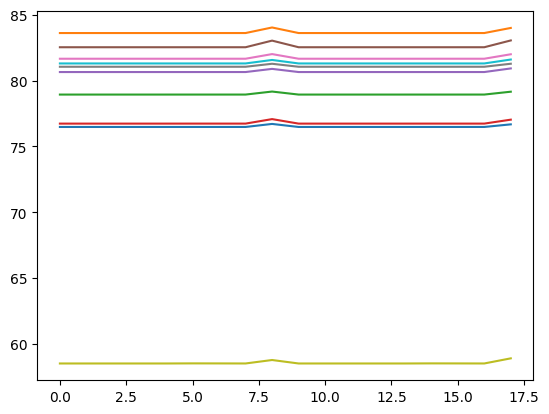

In [51]:
data = df[df.columns[0:-1]].to_numpy()
#data = df[[0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18]].to_numpy()
#print(data)

for i in range(10):
    plt.plot(data[i, :], label=str(i))
#plt.legend()
#plt.semilogy() 
plt.show()


(9957, 18)


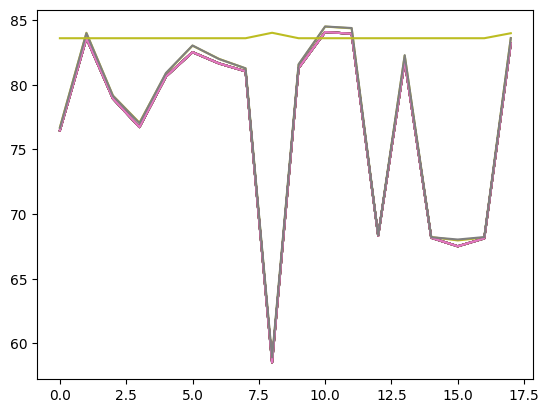

In [45]:
ids = df['Sat_ID'].to_numpy()

ids_sat = [2, 3, 4, 5, 6, 7, 8, 9, 13, 16,
     17, 18, 22, 23, 24, 25, 26, 28, 29, 30,
     33, 36, 38, 39, 40, 42, 43, 44, 46, 48,
     49, 50, 51, 57, 65, 67, 68, 69, 71, 72,
     73, 74, 77, 78, 79, 81, 82, 85, 87, 88,
     89, 90, 92, 93, 94, 96, 99, 103, 104, 107,
     109, 110, 111, 112, 114, 115]

#show_unique_and_repeated_elements(ids)
_,_,id = find_not_common_elements(ids, ids_sat)


# Create a boolean array where each element is True if the corresponding element in ids is in id
id_filter = np.isin(ids, id)

data_filter = data[id_filter]

print(data_filter.shape)

plt.plot(data_filter[0:18])
plt.plot(data_filter[1])



#print(ids==17)



PCA Analisis

Reduced Data:
 [[-5.69198692e+00  2.42503792e-02]
 [-3.60374493e+01  1.34004013e-01]
 [-1.61324224e+01 -1.32829964e-02]
 ...
 [ 1.33559577e+01 -1.12414703e-01]
 [ 8.45341767e+01  2.12279411e-01]
 [ 9.70900724e+01  2.59218152e-01]]


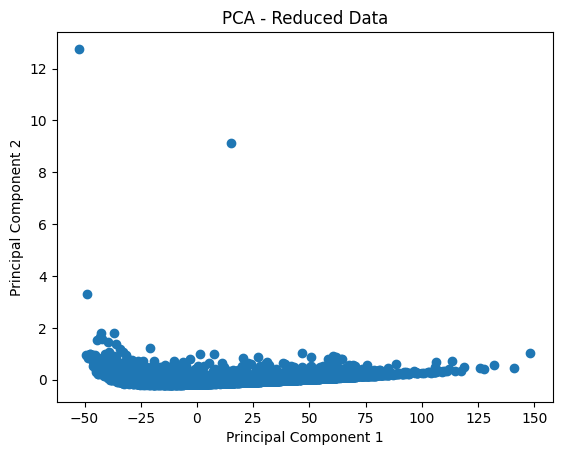

Explained Variance Ratio:
 [9.99938954e-01 6.06239052e-05]


In [54]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Generate a sample dataset

data_pca = data_filter
#data_pca = data
# Perform PCA using scikit-learn
num_components = 2
pca = PCA(n_components=num_components)
X_reduced_2 = pca.fit_transform(data_pca)

# Print the reduced data
print("Reduced Data:\n", X_reduced_2)

# Plot the reduced data
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Reduced Data')
plt.show()

# Explained variance ratio
print("Explained Variance Ratio:\n", pca.explained_variance_ratio_)

Text(0.5, 0, 'Z Label')

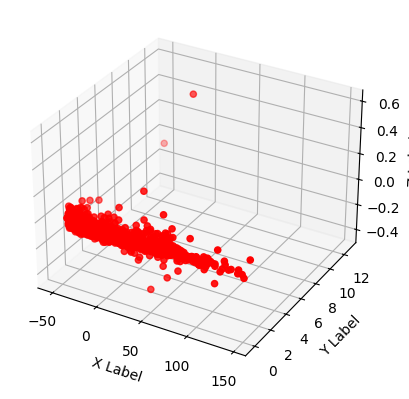

In [53]:
num_components = 3
pca = PCA(n_components=num_components)
X_reduced_3 = pca.fit_transform(data_pca)



# Create a new figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
ax.scatter(X_reduced_3[:, 0], X_reduced_3[:, 1], X_reduced_3[:, 2],c='r', marker='o')

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Train the Neural Network With the characteristics

In [ ]:
df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(df, ycol, xcols, ratio = 0.5)

cls = GradientBoostingClassifier(n_estimators=10000)
cls.fit(X_train, Y_train)
train_score = cls.score(X_train, Y_train)
test_score = cls.score(X_test, Y_test)
print("The Train Score is {}".format(train_score))
print("The Test Score is {}".format(test_score))

# IQ Imbalance Features 

Estimated gain mismatch g_hat_I: 0.03496991886621988
Estimated gain mismatch g_hat_Q: 0.037365715054271664
Estimated phase mismatch phi_hat_I: 163.17446236603357
Estimated phase mismatch phi_hat_Q: 81.58723


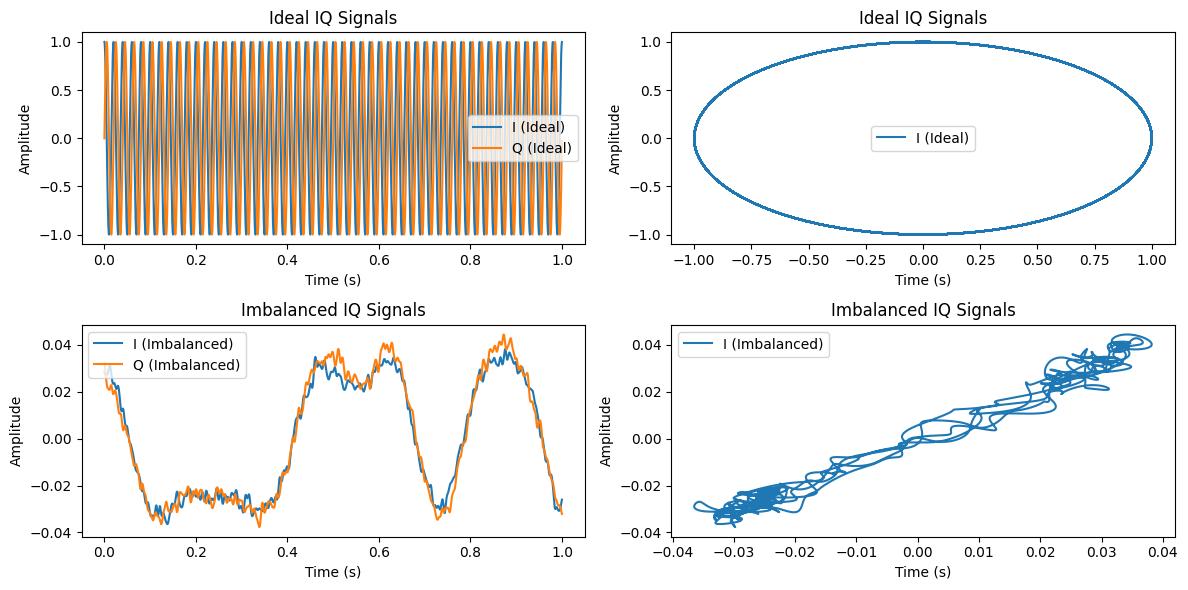

In [4]:
import numpy as np



# Step 1: Generate Example IQ Signals with Imbalance
# Parameters
fs = 11000  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector

# Ideal signal (no imbalance)
f = 50  # Frequency of the signal
r_I = np.cos(2 * np.pi * f * t)
r_Q = np.sin(2 * np.pi * f * t)

# Introduce gain and phase imbalance
gain_imbalance = 1.6  # Gain mismatch (e.g., 20% more gain in I)
phase_imbalance = 20  # Phase mismatch in degrees

# Convert phase imbalance to radians
phase_imbalance_rad = np.deg2rad(phase_imbalance)

# Imbalanced signals
Y_I = gain_imbalance * r_I
Y_Q = np.sin(2 * np.pi * f * t + phase_imbalance_rad)


Y_I = samples[0,:,0]
Y_Q = samples[0,:,1]


# Calculate expectations
E_YI2 = np.mean(Y_I**2)
E_YQ2 = np.mean(Y_Q**2)
E_rI2 = np.mean(r_I**2)
E_rQ2 = np.mean(r_Q**2)
E_YIYQ = np.mean(Y_I * Y_Q)


# Estimate gain mismatch parameters
g_hat_I = np.sqrt(E_YI2 / E_rQ2)
g_hat_Q = np.sqrt(E_YQ2 / E_rI2)

# Estimate phase mismatch parameters
phi_hat_Q = np.arcsin(E_YIYQ / np.sqrt(E_YI2 * E_YQ2))
phi_hat_I = 2 * phi_hat_Q

# Compensate the IQ signals
#r_hat_I = (Y_I - g_hat_I * r_Q * np.cos(phi_hat_I)) / g_hat_I / np.sin(phi_hat_I)
#r_hat_Q = (Y_Q + g_hat_Q * r_I * np.sin(phi_hat_Q)) / g_hat_Q / np.cos(phi_hat_Q)

# Print estimated parameters
print("Estimated gain mismatch g_hat_I:", g_hat_I)
print("Estimated gain mismatch g_hat_Q:", g_hat_Q)
print("Estimated phase mismatch phi_hat_I:", np.rad2deg(phi_hat_I))
print("Estimated phase mismatch phi_hat_Q:", np.rad2deg(phi_hat_Q))

# Verification (Optional)
# Check if the compensated signals have zero mean and unit variance
#print("Mean of compensated r_hat_I:", np.mean(r_hat_I))
#print("Variance of compensated r_hat_I:", np.var(r_hat_I))
#print("Mean of compensated r_hat_Q:", np.mean(r_hat_Q))
#print("Variance of compensated r_hat_Q:", np.var(r_hat_Q))


# Plot the ideal and imbalanced signals for visualization
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(t, r_I, label='I (Ideal)')
plt.plot(t, r_Q, label='Q (Ideal)')
plt.title('Ideal IQ Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t, Y_I, label='I (Imbalanced)')
plt.plot(t, Y_Q, label='Q (Imbalanced)')
plt.title('Imbalanced IQ Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(r_I, r_Q, label='I (Ideal)')
plt.title('Ideal IQ Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(Y_I,Y_Q, label='I (Imbalanced)')
plt.title('Imbalanced IQ Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

